><strong>Problem Overview:</strong> Spelling error correction is the task of automatically correcting spelling errors in text; e.g. [I followed his advcie -> I followed his advice]. It can be used to not only help language learners improve their writing erros, but also alert native speakers to accidental mistakes or typos.<br>
The aim of the task is to produce a correctly spelled sentence given a incorrectly spelled sentence.

><strong>Business Problem: </strong> By building the automated spelling error correction. We can create automated tools for writing English scientific texts, Filtering out sentences that need spelling improvements, evaluating articles, etc. These all mentioned tasks are done manually so, by automating this process we can save both time and money for the company.

><strong>ML formulation: </strong>Building a model using techniques like Encoder-Decoder architecture, Bidirectional LSTM with attention mechanism, etc. can be used.

><strong>Performance metric: </strong>BLEU Score<br>
Bilingual Evaluation Understudy(BLEU) is a metric for comparing machine translated sentence to one or more reference setences. The metric ranges on scale of 0 to 1, in an attempt to measure the adequacy and fluency of the MT output. the more overlap there is with their human reference translations and thus, the better the translation.<br>
The BLEU is programming task to compare n-grams of the translated sentences with the reference sentence and count the number of matches. The more the matches the better the performance.

In [1]:
import os
import re
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import*
from nltk.translate.bleu_score import sentence_bleu

warnings.filterwarnings('ignore')

# EDA

<strong>Preprocessing data: </strong>Text files which we need to combine to introduce spelling errors in the dataset. So, that we can train model for spelling error correction.

In [2]:
text_files = os.listdir('data')
text_files

['nietzsche.txt',
 'pride_and_prejudice.txt',
 'shakespeare.txt',
 'war_and_peace.txt',
 'wonderland.txt']

In [3]:
REMOVE_CHARS = '[#$%"\+@<=>!&,-.?:;()*\[\]\'^_`{|}~/\d\t\r\x0b\x0c]'
train_text = ''
for filename in text_files[:-1]:
    file = open('data/'+filename).read().split()
    train_text += ' '.join([re.sub(REMOVE_CHARS, '', token) for token in file])+' '

In [4]:
from nltk import ngrams

unigram_train_data = set([token for token in train_text.split()])
unigram_train_data = list(filter(None, set(unigram_train_data)))

bigram_train_data = list(ngrams(train_text.split(), 2))
bigram_train_data = [' '.join(x) for x in bigram_train_data]

trigram_train_data = list(ngrams(train_text.split(), 3))
trigram_train_data = [' '.join(x) for x in trigram_train_data]

print('Size of unigram train data:', len(unigram_train_data))
print('Size of bigram train data:', len(bigram_train_data))
print('Size of trigram train data:', len(trigram_train_data))

Size of unigram train data: 36821
Size of bigram train data: 983848
Size of trigram train data: 983847


In [5]:
file = open('data/'+text_files[-1]).read().split()
test_text = ' '.join([re.sub(REMOVE_CHARS, '', token) for token in file])

In [6]:
from nltk import ngrams

unigram_test_data = set([token for token in test_text.split()])
unigram_test_data = list(filter(None, set(unigram_test_data)))

bigram_test_data = list(ngrams(test_text.split(), 2))
bigram_test_data = [' '.join(x) for x in bigram_test_data]

trigram_test_data = list(ngrams(test_text.split(), 3))
trigram_test_data = [' '.join(x) for x in trigram_test_data]

print('Size of unigram test data:', len(unigram_test_data))
print('Size of bigram test data:', len(bigram_test_data))
print('Size of trigram test data:', len(trigram_test_data))

Size of unigram test data: 3152
Size of bigram test data: 26387
Size of trigram test data: 26386


In [7]:
unigram_length = []
for i in unigram_train_data:
    unigram_length.append(len(i))
    
bigram_length = []
for i in bigram_train_data:
    bigram_length.append(len(i))

trigram_length = []
for i in trigram_train_data:
    trigram_length.append(len(i))

In [8]:
for i in range(0,101,10):
    print(i,np.percentile(unigram_length, i), np.percentile(bigram_length, i), np.percentile(trigram_length, i))
for i in range(90,101):
    print(i,np.percentile(unigram_length, i), np.percentile(bigram_length, i), np.percentile(trigram_length, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(unigram_length, i), np.percentile(bigram_length, i), np.percentile(trigram_length, i))

0 1.0 3.0 5.0
10 5.0 6.0 11.0
20 6.0 7.0 12.0
30 6.0 8.0 13.0
40 7.0 9.0 14.0
50 8.0 9.0 15.0
60 8.0 10.0 16.0
70 9.0 11.0 17.0
80 10.0 12.0 18.0
90 12.0 14.0 21.0
100 27.0 35.0 47.0
90 12.0 14.0 21.0
91 12.0 14.0 21.0
92 12.0 15.0 21.0
93 12.0 15.0 22.0
94 12.0 15.0 22.0
95 13.0 16.0 22.0
96 13.0 16.0 23.0
97 14.0 17.0 24.0
98 14.0 18.0 25.0
99 16.0 19.0 26.0
100 27.0 35.0 47.0
99.1 16.0 20.0 27.0
99.2 16.0 20.0 27.0
99.3 16.0 20.0 27.0
99.4 17.0 20.0 28.0
99.5 17.0 21.0 28.0
99.6 17.0 21.0 28.0
99.7 18.0 22.0 29.0
99.8 19.0 22.0 30.0
99.9 20.0 24.0 32.0
100 27.0 35.0 47.0


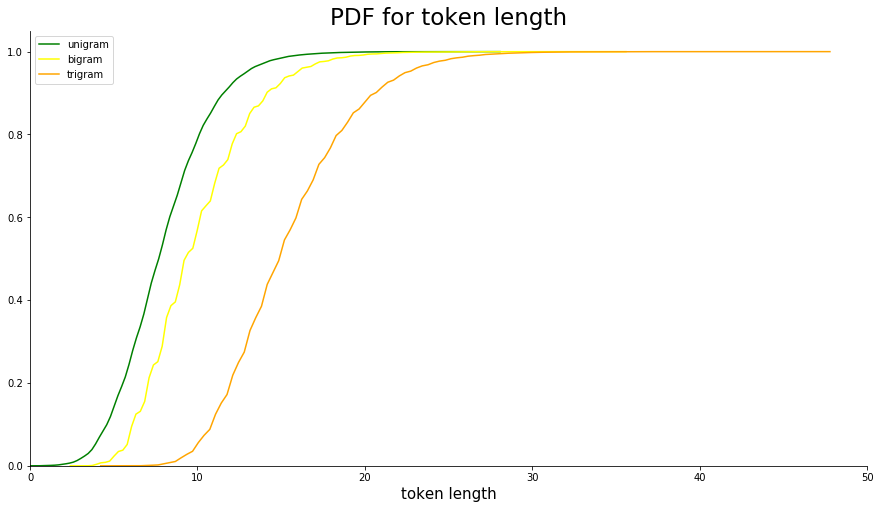

In [9]:
plt.figure(figsize = (15,8))
ax = sns.kdeplot(data = unigram_length, color='green', cumulative = True, label = 'unigram')
sns.kdeplot(data = bigram_length, color='yellow', cumulative = True, ax = ax, label = 'bigram')
sns.kdeplot(data = trigram_length, color='orange', cumulative = True, ax = ax, label = 'trigram')
plt.xlabel('token length', fontdict = {'fontsize':15})
plt.title('PDF for token length', fontdict = {'fontsize': 23})
ax.legend()
plt.xlim(0, 50)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

> <strong> Aim :</strong> Plot for determining the distribution token length of unigram, bigram, and trigram dataset.

> <strong>Conclusion : </strong><br>
1.&nbsp;99.9% of unigram token have length less than 20 characters.<br>
2.&nbsp;99.9% of biigram token have length less than 24 characters.<br>
3.&nbsp;99.9% of trigram token have length less than 32 characters.

In [10]:
def add_speling_errors(token, error_rate, VOCAB):
    """Add some artificial spelling mistakes."""
    assert(0.0 <= error_rate < 1.0)
    if len(token) < 3:
        return token
    rand = np.random.rand()
    # Here are 4 different ways spelling mistakes can occur,
    # each of which has equal chance.
    prob = error_rate / 4.0
    if rand < prob:
        # Replace a character with a random character.
        random_char_index = np.random.randint(len(token))
        token = token[:random_char_index] + np.random.choice(VOCAB) \
                + token[random_char_index + 1:]
    elif prob < rand < prob * 2:
        # Delete a character.
        random_char_index = np.random.randint(len(token))
        token = token[:random_char_index] + token[random_char_index + 1:]
    elif prob * 2 < rand < prob * 3:
        # Add a random character.
        random_char_index = np.random.randint(len(token))
        token = token[:random_char_index] + np.random.choice(VOCAB) \
                + token[random_char_index:]
    elif prob * 3 < rand < prob * 4:
        # Transpose 2 characters.
        random_char_index = np.random.randint(len(token) - 1)
        token = token[:random_char_index]  + token[random_char_index + 1] \
                + token[random_char_index] + token[random_char_index + 2:]
    else:
        # No spelling errors.
        pass
    return token

In [2]:
UNIGRAM_VOCAB = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', \
                 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', \
                 '<SOW>', '<EOW>']

NGRAM_VOCAB = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', \
               'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', \
               ' ', '<SOW>', '<EOW>']

In [12]:
unigram_maxlen = 20
unigram_train = []
for token in unigram_train_data:
    if len(token) < unigram_maxlen:
        point = [token, add_speling_errors(token, 0.5, UNIGRAM_VOCAB)]
        unigram_train.append(point)
unigram_train = pd.DataFrame(unigram_train, columns = ['output', 'input'])
unigram_train.head()

,output,input
0,magistrates,magistratse
1,Cookshops,Cookshops
2,aristocratic,arstocratic
3,graced,graced
4,wagging,wagigng


In [13]:
bigram_maxlen = 24
bigram_train = []
for token in bigram_train_data:
    if len(token) < bigram_maxlen:
        point = [token, add_speling_errors(token, 0.5, NGRAM_VOCAB)]
        bigram_train.append(point)
bigram_train = pd.DataFrame(bigram_train, columns = ['output', 'input'])
bigram_train.head()

,output,input
0,PREFACE SUPPOSING,PREFACE SUPPOSING
1,SUPPOSING that,SUPPOSINGt hat
2,that Truth,that TruEh
3,Truth is,Truth is
4,is a,si a


In [14]:
trigram_maxlen = 32
trigram_train = []
for token in trigram_train_data:
    if len(token) < trigram_maxlen:
        point = [token, add_speling_errors(token, 0.5, NGRAM_VOCAB)]
        trigram_train.append(point)
trigram_train = pd.DataFrame(trigram_train, columns = ['output', 'input'])
trigram_train.head()

,output,input
0,PREFACE SUPPOSING that,PREFACE SUPPOSIN that
1,SUPPOSING that Truth,SUPPOSsING that Truth
2,that Truth is,that Truth is
3,Truth is a,Truth si a
4,is a womanwhat,is a womanwhat


In [15]:
unigram_train['enc_inp'] = unigram_train['input'].astype(str).apply(lambda x: '<SOW> '+' '.join(list(x))+' <EOW>')
unigram_train['dec_inp'] = unigram_train['output'].astype(str).apply(lambda x: '<SOW> '+' '.join(list(x)))
unigram_train['dec_out'] = unigram_train['output'].astype(str).apply(lambda x: ' '.join(list(x))+' <EOW>')

bigram_train['enc_inp'] = bigram_train['input'].astype(str).apply(lambda x: '<SOW>*'+'*'.join(list(x))+'*<EOW>')
bigram_train['dec_inp'] = bigram_train['output'].astype(str).apply(lambda x: '<SOW>*'+'*'.join(list(x)))
bigram_train['dec_out'] = bigram_train['output'].astype(str).apply(lambda x: '*'.join(list(x))+'*<EOW>')

trigram_train['enc_inp'] = trigram_train['input'].astype(str).apply(lambda x: '<SOW>*'+'*'.join(list(x))+'*<EOW>')
trigram_train['dec_inp'] = trigram_train['output'].astype(str).apply(lambda x: '<SOW>*'+'*'.join(list(x)))
trigram_train['dec_out'] = trigram_train['output'].astype(str).apply(lambda x: '*'.join(list(x))+'*<EOW>')

In [16]:
unigram_train, unigram_val = train_test_split(unigram_train, test_size = 0.1, random_state = 0)
bigram_train, bigram_val = train_test_split(bigram_train, test_size = 0.1, random_state = 0)
trigram_train, trigram_val = train_test_split(trigram_train, test_size = 0.1, random_state = 0)

In [17]:
unigram_test = []
for token in unigram_test_data:
    if len(token) < unigram_maxlen:
        point = [token, add_speling_errors(token, 0.5, UNIGRAM_VOCAB)]
        unigram_test.append(point)
unigram_test = pd.DataFrame(unigram_test, columns = ['output', 'input'])
unigram_test.head()

,output,input
0,slatesll,slatesll
1,rumbling,rmubling
2,chance,chacne
3,bright,brnight
4,ridiculous,ridiculous


In [18]:
bigram_test = []
for token in bigram_test_data:
    if len(token) < bigram_maxlen:
        point = [token, add_speling_errors(token, 0.5, NGRAM_VOCAB)]
        bigram_test.append(point)
bigram_test = pd.DataFrame(bigram_test, columns = ['output', 'input'])
bigram_test.head()

,output,input
0,ï»¿ALICES ADVENTURES,ï»¿ALIECS ADVENTURES
1,ADVENTURES IN,ADVENTURES IN
2,IN WONDERLAND,IN WONDEtLAND
3,WONDERLAND Lewis,WONDERLAND Lewis
4,Lewis Carroll,Lewis Carrlol


In [19]:
trigram_test = []
for token in trigram_test_data:
    if len(token) < unigram_maxlen:
        point = [token, add_speling_errors(token, 0.5, NGRAM_VOCAB)]
        trigram_test.append(point)
trigram_test = pd.DataFrame(trigram_test, columns = ['output', 'input'])
trigram_test.head()

,output,input
0,IN WONDERLAND Lewis,IN WONDERoLAND Lewis
1,Lewis Carroll THE,Lewis Carroll THE
2,EDITION CHAPTER I,EDITION CHATPER I
3,CHAPTER I Down,CHAPTRE I Down
4,I Down the,I Down the


In [100]:
unigram_train.to_csv('unigram_train.csv')
unigram_test.to_csv('unigram_test.csv')
unigram_val.to_csv('unigram_val.csv')

bigram_train.to_csv('bigram_train.csv')
bigram_test.to_csv('bigram_test.csv')
bigram_val.to_csv('bigram_val.csv')

trigram_train.to_csv('trigram_train.csv')
trigram_test.to_csv('trigram_test.csv')
trigram_val.to_csv('trigram_val.csv')

In [20]:
print('Shape of unigram train set :',unigram_train.shape)
print('Shape of unigram test set :',unigram_test.shape)
print('Shape of unigram validation set :', unigram_val.shape)

print('\nShape of bigram train set :',bigram_train.shape)
print('Shape of bigram test set :',bigram_test.shape)
print('Shape of bigram validation set :', bigram_val.shape)

print('\nShape of trigram train set :',trigram_train.shape)
print('Shape of trigram test set :',trigram_test.shape)
print('Shape of trigram validation set :', trigram_val.shape)

Shape of unigram train set : (33101, 5)
Shape of unigram test set : (3150, 2)
Shape of unigram validation set : (3678, 5)

Shape of bigram train set : (884533, 5)
Shape of bigram test set : (26377, 2)
Shape of bigram validation set : (98282, 5)

Shape of trigram train set : (884550, 5)
Shape of trigram test set : (24586, 2)
Shape of trigram validation set : (98284, 5)


In [21]:
print(unigram_train.isnull().sum(), unigram_val.isnull().sum(), unigram_test.isnull().sum())
print(bigram_train.isnull().sum(), bigram_val.isnull().sum(), bigram_test.isnull().sum())
print(trigram_train.isnull().sum(), trigram_val.isnull().sum(), trigram_test.isnull().sum())

output     0
input      0
enc_inp    0
dec_inp    0
dec_out    0
dtype: int64 output     0
input      0
enc_inp    0
dec_inp    0
dec_out    0
dtype: int64 output    0
input     0
dtype: int64
output     0
input      0
enc_inp    0
dec_inp    0
dec_out    0
dtype: int64 output     0
input      0
enc_inp    0
dec_inp    0
dec_out    0
dtype: int64 output    0
input     0
dtype: int64
output     0
input      0
enc_inp    0
dec_inp    0
dec_out    0
dtype: int64 output     0
input      0
enc_inp    0
dec_inp    0
dec_out    0
dtype: int64 output    0
input     0
dtype: int64


# Modeling

In [14]:
unigram_train = pd.read_csv('unigram_train.csv', index_col = 0)
unigram_test = pd.read_csv('unigram_test.csv', index_col = 0)
unigram_val = pd.read_csv('unigram_val.csv', index_col = 0)

bigram_train = pd.read_csv('bigram_train.csv', index_col = 0)
bigram_test = pd.read_csv('bigram_test.csv', index_col = 0)
bigram_val = pd.read_csv('bigram_val.csv', index_col = 0)

trigram_train = pd.read_csv('trigram_train.csv', index_col = 0)
trigram_test = pd.read_csv('trigram_test.csv', index_col = 0)
trigram_val = pd.read_csv('trigram_val.csv', index_col = 0)

In [16]:
def split_on_star(input_data):
    return tf.strings.split(input_data, sep = '*')

In [15]:
batch_size = 128

In [11]:
unigram_maxlen = 20
bigram_maxlen = 24
trigram_maxlen = 32

In [17]:
unigram_vec = TextVectorization(output_sequence_length= unigram_maxlen+2, standardize = None, split='whitespace', max_tokens = len(UNIGRAM_VOCAB)+2, output_mode='int')
unigram_vec.adapt(UNIGRAM_VOCAB)

bigram_vec = TextVectorization(output_sequence_length= bigram_maxlen+2, standardize = None, split = split_on_star, max_tokens = len(NGRAM_VOCAB)+2, output_mode='int')
bigram_vec.adapt(NGRAM_VOCAB)

trigram_vec = TextVectorization(output_sequence_length= trigram_maxlen+2, standardize = None, split = split_on_star, max_tokens = len(NGRAM_VOCAB)+2, output_mode='int')
trigram_vec.adapt(NGRAM_VOCAB)

unigram_index_to_word = {idx: word for idx, word in enumerate(unigram_vec.get_vocabulary())}
unigram_word_to_index = {word: idx for idx, word in enumerate(unigram_vec.get_vocabulary())}

bigram_index_to_word = {idx: word for idx, word in enumerate(bigram_vec.get_vocabulary())}
bigram_word_to_index = {word: idx for idx, word in enumerate(bigram_vec.get_vocabulary())}

trigram_index_to_word = {idx: word for idx, word in enumerate(trigram_vec.get_vocabulary())}
trigram_word_to_index = {word: idx for idx, word in enumerate(trigram_vec.get_vocabulary())}

def unigram_mapping(x):
    enc_inp = unigram_vec(x[:, 2])
    dec_inp = unigram_vec(x[:, 3])
    dec_out = unigram_vec(x[:, 4])
    return (enc_inp, dec_inp), dec_out

def bigram_mapping(x):
    enc_inp = bigram_vec(x[:, 2])
    dec_inp = bigram_vec(x[:, 3])
    dec_out = bigram_vec(x[:, 4])
    return (enc_inp, dec_inp), dec_out

def trigram_mapping(x):
    enc_inp = trigram_vec(x[:, 2])
    dec_inp = trigram_vec(x[:, 3])
    dec_out = trigram_vec(x[:, 4])
    return (enc_inp, dec_inp), dec_out

unigram_train_dataset = tf.data.Dataset.from_tensor_slices(unigram_train.values).repeat().batch(batch_size).map(unigram_mapping).prefetch(1)
unigram_val_dataset = tf.data.Dataset.from_tensor_slices(unigram_val.values).repeat().batch(batch_size).map(unigram_mapping).prefetch(1)

bigram_train_dataset = tf.data.Dataset.from_tensor_slices(bigram_train.values).repeat().batch(batch_size).map(bigram_mapping).prefetch(1)
bigram_val_dataset = tf.data.Dataset.from_tensor_slices(bigram_val.values).repeat().batch(batch_size).map(bigram_mapping).prefetch(1)

trigram_train_dataset = tf.data.Dataset.from_tensor_slices(trigram_train.values).repeat().batch(batch_size).map(trigram_mapping).prefetch(1)
trigram_val_dataset = tf.data.Dataset.from_tensor_slices(trigram_val.values).repeat().batch(batch_size).map(trigram_mapping).prefetch(1)

a = unigram_train_dataset.as_numpy_iterator()
next(a)

((array([[54, 26, 23, ...,  0,  0,  0],
         [54, 42, 51, ...,  0,  0,  0],
         [54, 35,  7, ...,  0,  0,  0],
         ...,
         [54, 10, 27, ...,  0,  0,  0],
         [54, 15,  7, ...,  0,  0,  0],
         [54,  7, 14, ...,  0,  0,  0]], dtype=int64),
  array([[54, 26, 23, ...,  0,  0,  0],
         [54, 42, 33, ...,  0,  0,  0],
         [54, 35,  7, ...,  0,  0,  0],
         ...,
         [54, 10, 27, ...,  0,  0,  0],
         [54, 15,  7, ...,  0,  0,  0],
         [54,  7, 14, ...,  0,  0,  0]], dtype=int64)),
 array([[26, 23, 22, ...,  0,  0,  0],
        [42, 33, 51, ...,  0,  0,  0],
        [35,  7, 25, ...,  0,  0,  0],
        ...,
        [10, 27,  6, ...,  0,  0,  0],
        [15,  7, 14, ...,  0,  0,  0],
        [ 7, 14, 24, ...,  0,  0,  0]], dtype=int64))

<h2>1. Seq2Seq</h2>

In [18]:
class Encoder(tf.keras.Model):
    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.lstm_size = lstm_size
        #Initialize Embedding layer
        self.enc_embed = Embedding(input_dim = inp_vocab_size, output_dim = embedding_size, input_length= input_length)
        #Intialize Encoder LSTM layer
        self.enc_lstm = LSTM(lstm_size, return_sequences = True, return_state = True, dropout = 0.4)

    def call(self,input_sequence,states):
        embedding = self.enc_embed(input_sequence)
        output_state, enc_h, enc_c = self.enc_lstm(embedding, initial_state = states)
        return output_state, enc_h, enc_c
    
    def initialize_states(self,batch_size):
        return [tf.zeros((batch_size, self.lstm_size)), tf.zeros((batch_size, self.lstm_size))]

class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        #Initialize Embedding layer
        self.dec_embed = Embedding(input_dim = out_vocab_size, output_dim = embedding_size, input_length = input_length)
        #Intialize Decoder LSTM layer
        self.dec_lstm = LSTM(lstm_size, return_sequences = True, return_state = True, dropout = 0.4)
    
    def call(self,input_sequence, initial_states):
        embedding = self.dec_embed(input_sequence)
        output_state, dec_h, dec_c = self.dec_lstm(embedding, initial_state = initial_states)
        return output_state, dec_h, dec_c

class Encoder_decoder(tf.keras.Model): 
    def __init__(self,*params):
        super().__init__()
        #Create encoder object
        self.encoder = Encoder(inp_vocab_size = params[0], embedding_size = params[2], lstm_size = params[3], input_length = params[4])
        #Create decoder object
        self.decoder = Decoder(out_vocab_size = params[1], embedding_size = params[2], lstm_size = params[3], input_length = params[5])
        #Intialize Dense layer(out_vocab_size) with activation='softmax'
        self.dense = Dense(params[1], activation='softmax')
    
    def call(self, params, training = True):
        enc_inp, dec_inp = params[0], params[1]
        # print(enc_inp, dec_inp)
        initial_state = self.encoder.initialize_states(batch_size)
        output_state, enc_h, enc_c = self.encoder(enc_inp, initial_state)
        output, _, _ = self.decoder(dec_inp ,[enc_h, enc_c])
        output = Dropout(0.5)(output)
        return self.dense(output)

class pred_Encoder_decoder(tf.keras.Model): 
    def __init__(self,*params):
        super().__init__()
        #Create encoder object
        self.encoder = Encoder(inp_vocab_size = params[0], embedding_size = params[2], lstm_size = params[3], input_length = params[4])
        #Create decoder object
        self.decoder = Decoder(out_vocab_size = params[1], embedding_size = params[2], lstm_size = params[3], input_length = params[5])
        #Intialize Dense layer(out_vocab_size) with activation='softmax'
        self.dense = Dense(params[1], activation='softmax')
        self.word_to_index = params[6]
    
    def call(self, params):
        enc_inp = params[0]
        initial_state = self.encoder.initialize_states(1)
        output_state, enc_h, enc_c = self.encoder(enc_inp, initial_state)
        pred = tf.expand_dims([self.word_to_index['<SOW>']], 0)
        dec_h = enc_h
        dec_c = enc_c
        all_pred = []
        for t in range(max_len):  
            pred, dec_h,dec_c = self.decoder(pred, [dec_h, dec_c])
            pred = self.dense(pred)
            pred = tf.argmax(pred, axis = -1)
            all_pred.append(pred)
        return all_pred

In [19]:
def predict(seq, vectorizer, index_to_word, gram ='uni'):
    if gram == 'uni':
        seq = ' '.join(list(seq))
        seq = '<SOW> '+seq+' <EOW>'
    else:
        seq = '*'.join(list(seq))
        seq = '<SOW>*'+seq+'*<EOW>'
    seq = vectorizer([seq])
    pred = pred_model.predict(tf.expand_dims(seq, 0))
    output = []
    for i in pred:
        word = index_to_word[i[0][0]]
        if word == '<EOW>':
            break
        output.append(word)
    return ''.join(output)

<h3>1.1 UniGram </h3>

In [67]:
vocab_size = len(vec.get_vocabulary())
embedding_dim = 100
lstm_size = 256
max_len = 22

In [20]:
model = Encoder_decoder(vocab_size, vocab_size, embedding_dim, lstm_size, max_len, max_len)
model.compile(optimizer = 'Adam',loss = 'sparse_categorical_crossentropy')

callbacks = [ModelCheckpoint('seq2seq.h5', save_best_only= True, verbose = 1),
             EarlyStopping(patience = 5, verbose = 1), 
             ReduceLROnPlateau(patience = 3, verbose = 1)]

model.fit(x = unigram_train_dataset, 
          steps_per_epoch = unigram_train.shape[0]//batch_size,
          validation_data = unigram_val_dataset,
          validation_steps = unigram_val.shape[0]//batch_size,
          epochs = 50,
          verbose = 1,
          callbacks = callbacks)

Epoch 1/50
258/258 [==============================] - ETA: 0s - loss: 1.3088
Epoch 00001: val_loss improved from inf to 1.08792, saving model to seq2seq.h5
258/258 [==============================] - 4s 14ms/step - loss: 1.3088 - val_loss: 1.0879
Epoch 2/50
258/258 [==============================] - ETA: 0s - loss: 1.0246
Epoch 00002: val_loss improved from 1.08792 to 0.93814, saving model to seq2seq.h5
258/258 [==============================] - 3s 12ms/step - loss: 1.0246 - val_loss: 0.9381
Epoch 3/50
256/258 [============================>.] - ETA: 0s - loss: 0.9280
Epoch 00003: val_loss improved from 0.93814 to 0.84624, saving model to seq2seq.h5
258/258 [==============================] - 3s 12ms/step - loss: 0.9278 - val_loss: 0.8462
Epoch 4/50
256/258 [============================>.] - ETA: 0s - loss: 0.8515
Epoch 00004: val_loss improved from 0.84624 to 0.78058, saving model to seq2seq.h5
258/258 [==============================] - 3s 12ms/step - loss: 0.8513 - val_loss: 0.7806
Epoc

Epoch 34/50
255/258 [============================>.] - ETA: 0s - loss: 0.1346
Epoch 00034: val_loss improved from 0.14277 to 0.14092, saving model to seq2seq.h5
258/258 [==============================] - 3s 13ms/step - loss: 0.1344 - val_loss: 0.1409
Epoch 35/50
255/258 [============================>.] - ETA: 0s - loss: 0.1295
Epoch 00035: val_loss did not improve from 0.14092
258/258 [==============================] - 4s 14ms/step - loss: 0.1295 - val_loss: 0.1442
Epoch 36/50
257/258 [============================>.] - ETA: 0s - loss: 0.1263
Epoch 00036: val_loss did not improve from 0.14092
258/258 [==============================] - 3s 13ms/step - loss: 0.1263 - val_loss: 0.1426
Epoch 37/50
256/258 [============================>.] - ETA: 0s - loss: 0.1225
Epoch 00037: val_loss did not improve from 0.14092

Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
258/258 [==============================] - 3s 13ms/step - loss: 0.1224 - val_loss: 0.1424
Epoch 38/5

In [70]:
pred_model = pred_Encoder_decoder(vocab_size, vocab_size, embedding_dim, lstm_size, max_len, max_len)
pred_model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy')
pred_model.build(input_shape=(None, 1, max_len))
pred_model.load_weights('seq2seq.h5')

In [71]:
sentence = unigram_train['input'].values[5]
print('input : ', sentence)
result = predict(sentence, unigram_vec, unigram_index_to_word, gram = 'uni')
print('predicted output : ',result)
print('actual output :', unigram_train['output'].values[5])

input :  qitted
predicted output :  quitted
actual output : quitted


In [72]:
sentence = unigram_train['input'].values[11]
print('input : ', sentence)
result = predict(sentence, unigram_vec, unigram_index_to_word, gram = 'uni')
print('predicted output : ',result)
print('actual output :', unigram_train['output'].values[11])

input :  fortissiemus
predicted output :  fortissimeus
actual output : fortissimus


In [73]:
sentence = unigram_train['input'].values[14]
print('input : ', sentence)
result = predict(sentence, unigram_vec, unigram_index_to_word, gram = 'uni')
print('predicted output : ',result)
print('actual output :', unigram_train['output'].values[14])

input :  numbeGr
predicted output :  number
actual output : number


In [27]:
val_bleu = 0
for i in tqdm(range(val.shape[0])):
    inp = unigram_val['input'].values[i]
    out = unigram_val['output'].values[i]
    pred = predict(inp, unigram_vec, unigram_index_to_word, gram = 'uni')
    val_bleu += sentence_bleu([out], pred)

train_bleu = 0
for i in tqdm(range(train.shape[0])):
    inp = unigram_train['input'].values[i];
    out = unigram_train['output'].values[i]
    pred = predict(inp, unigram_vec, unigram_index_to_word, gram = 'uni')
    train_bleu += sentence_bleu([out], pred)

test_bleu = 0
for i in tqdm(range(test.shape[0])):
    inp = unigram_test['input'].values[i]
    out = unigram_test['output'].values[i]
    pred = predict(inp, unigram_vec, unigram_index_to_word, gram = 'uni')
    test_bleu += sentence_bleu([out], pred)
    
print('BLEU Score on train: ',train_bleu/unigram_train.shape[0])
print('BLEU Score on val: ',val_bleu/unigram_val.shape[0])
print('BLEU Score on test: ',test_bleu/unigram_test.shape[0])

100%|██████████████████████████████████████████████████████████████████████████████| 3150/3150 [02:46<00:00, 18.89it/s]

BLEU Score on train:  0.8349934632437717
BLEU Score on val:  0.7469809366693739
BLEU Score on test:  0.6843990465288321


<h3>1.2 BiGram </h3>

In [20]:
vocab_size = len(bigram_vec.get_vocabulary())
embedding_dim = 100
lstm_size = 256
max_len = 26

In [28]:
model = Encoder_decoder(vocab_size, vocab_size, embedding_dim, lstm_size, max_len, max_len)
model.compile(optimizer = 'Adam',loss = 'sparse_categorical_crossentropy')

callbacks = [ModelCheckpoint('seq2seq_bigram.h5', save_best_only= True, verbose = 1),
             EarlyStopping(patience = 5, verbose = 1), 
             ReduceLROnPlateau(patience = 3, verbose = 1)]

model.fit(x = bigram_train_dataset, 
          steps_per_epoch = bigram_train.shape[0]//batch_size,
          validation_data = bigram_val_dataset,
          validation_steps = bigram_val.shape[0]//batch_size,
          epochs = 50,
          verbose = 1,
          callbacks = callbacks)

Epoch 1/50
6910/6910 [==============================] - ETA: 0s - loss: 0.5047
Epoch 00001: val_loss improved from inf to 0.11996, saving model to seq2seq_bigram.h5
6910/6910 [==============================] - 96s 14ms/step - loss: 0.5047 - val_loss: 0.1200
Epoch 2/50
6907/6910 [============================>.] - ETA: 0s - loss: 0.1247
Epoch 00002: val_loss improved from 0.11996 to 0.06599, saving model to seq2seq_bigram.h5
6910/6910 [==============================] - 100s 14ms/step - loss: 0.1246 - val_loss: 0.0660
Epoch 3/50
6907/6910 [============================>.] - ETA: 0s - loss: 0.0858
Epoch 00003: val_loss improved from 0.06599 to 0.05437, saving model to seq2seq_bigram.h5
6910/6910 [==============================] - 104s 15ms/step - loss: 0.0858 - val_loss: 0.0544
Epoch 4/50
6907/6910 [============================>.] - ETA: 0s - loss: 0.0722
Epoch 00004: val_loss improved from 0.05437 to 0.04924, saving model to seq2seq_bigram.h5
6910/6910 [==============================] - 10

Epoch 33/50
6910/6910 [==============================] - ETA: 0s - loss: 0.0292
Epoch 00033: val_loss improved from 0.03222 to 0.03200, saving model to seq2seq_bigram.h5
6910/6910 [==============================] - 109s 16ms/step - loss: 0.0292 - val_loss: 0.0320
Epoch 34/50
6908/6910 [============================>.] - ETA: 0s - loss: 0.0286
Epoch 00034: val_loss improved from 0.03200 to 0.03186, saving model to seq2seq_bigram.h5
6910/6910 [==============================] - 110s 16ms/step - loss: 0.0286 - val_loss: 0.0319
Epoch 35/50
6907/6910 [============================>.] - ETA: 0s - loss: 0.0282
Epoch 00035: val_loss improved from 0.03186 to 0.03174, saving model to seq2seq_bigram.h5
6910/6910 [==============================] - 108s 16ms/step - loss: 0.0282 - val_loss: 0.0317
Epoch 36/50
6908/6910 [============================>.] - ETA: 0s - loss: 0.0279
Epoch 00036: val_loss improved from 0.03174 to 0.03169, saving model to seq2seq_bigram.h5
6910/6910 [===========================

In [21]:
pred_model = pred_Encoder_decoder(vocab_size, vocab_size, embedding_dim, lstm_size, max_len, max_len, bigram_word_to_index)
pred_model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy')
pred_model.build(input_shape=(None, 1, max_len))
pred_model.load_weights('seq2seq_bigram.h5')

In [42]:
sentence = bigram_train['input'].values[4]
print('input : ', sentence)
result = predict(sentence, bigram_vec, bigram_index_to_word, gram = 'bi')
print('predicted output : ',result)
print('actual output :', bigram_train['output'].values[4])

input :  no Lne
predicted output :  no one
actual output : no one


In [45]:
sentence = bigram_train['input'].values[6]
print('input : ', sentence)
result = predict(sentence, bigram_vec, bigram_index_to_word, gram = 'bi')
print('predicted output : ',result)
print('actual output :', bigram_train['output'].values[6])

input :  for themseves
predicted output :  for themselves
actual output : for themselves


In [46]:
sentence = bigram_train['input'].values[7]
print('input : ', sentence)
result = predict(sentence, bigram_vec, bigram_index_to_word, gram = 'bi')
print('predicted output : ',result)
print('actual output :', bigram_train['output'].values[7])

input :  detil of
predicted output :  detail of
actual output : detail of


In [25]:
val_bleu/bigram_val.shape[0]

0.9467181213926804

  3%|██▍                                                                     | 30534/884533 [30:10<13:29:26, 17.58it/s]

In [22]:
val_bleu = 0
for i in tqdm(range(bigram_val.shape[0])):
    inp = bigram_val['input'].values[i]
    out = bigram_val['output'].values[i]
    pred = predict(inp, bigram_vec, bigram_index_to_word, gram = 'bi')
    val_bleu += sentence_bleu([out], pred)

train_bleu = 0
for i in tqdm(range(bigram_train.shape[0])):
    inp = bigram_train['input'].values[i];
    out = bigram_train['output'].values[i]
    pred = predict(inp, bigram_vec, bigram_index_to_word, gram = 'bi')
    train_bleu += sentence_bleu([out], pred)

test_bleu = 0
for i in tqdm(range(bigram_test.shape[0])):
    inp = bigram_test['input'].values[i]
    out = bigram_test['output'].values[i]
    pred = predict(inp, bigram_vec, bigram_index_to_word, gram = 'bi')
    test_bleu += sentence_bleu([out], pred)
    
print('BLEU Score on train: ',train_bleu/bigram_train.shape[0])
print('BLEU Score on val: ',val_bleu/bigram_val.shape[0])
print('BLEU Score on test: ',test_bleu/bigram_test.shape[0])

  3%|██▍                                                                     | 30394/884533 [29:43<14:21:38, 16.52it/s]Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x000002854C787828>
Traceback (most recent call last):
  File "C:\Users\Vineet Mukesh Haswan\anaconda3\lib\weakref.py", line 358, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt
  3%|██▍                                                                     | 30534/884533 [29:51<13:29:26, 17.58it/s]

KeyboardInterrupt: 

<h3>1.3 TriGram</h3>

In [50]:
vocab_size = len(bigram_vec.get_vocabulary())
embedding_dim = 100
lstm_size = 256
max_len = 34

In [52]:
model = Encoder_decoder(vocab_size, vocab_size, embedding_dim, lstm_size, max_len, max_len)
model.compile(optimizer = 'Adam',loss = 'sparse_categorical_crossentropy')

callbacks = [ModelCheckpoint('seq2seq_trigram.h5', save_best_only= True, verbose = 1),
             EarlyStopping(patience = 5, verbose = 1), 
             ReduceLROnPlateau(patience = 3, verbose = 1)]

model.fit(x = trigram_train_dataset, 
          steps_per_epoch = trigram_train.shape[0]//batch_size,
          validation_data = trigram_val_dataset,
          validation_steps = trigram_val.shape[0]//batch_size,
          epochs = 50,
          verbose = 1,
          callbacks = callbacks)

Epoch 1/50
6909/6910 [============================>.] - ETA: 0s - loss: 0.7007
Epoch 00001: val_loss improved from inf to 0.21410, saving model to seq2seq_trigram.h5
6910/6910 [==============================] - 122s 18ms/step - loss: 0.7007 - val_loss: 0.2141
Epoch 2/50
6910/6910 [==============================] - ETA: 0s - loss: 0.1938
Epoch 00002: val_loss improved from 0.21410 to 0.08815, saving model to seq2seq_trigram.h5
6910/6910 [==============================] - 129s 19ms/step - loss: 0.1938 - val_loss: 0.0882
Epoch 3/50
6909/6910 [============================>.] - ETA: 0s - loss: 0.1176
Epoch 00003: val_loss improved from 0.08815 to 0.06765, saving model to seq2seq_trigram.h5
6910/6910 [==============================] - 129s 19ms/step - loss: 0.1176 - val_loss: 0.0676
Epoch 4/50
6910/6910 [==============================] - ETA: 0s - loss: 0.0948
Epoch 00004: val_loss improved from 0.06765 to 0.05852, saving model to seq2seq_trigram.h5
6910/6910 [==============================]

Epoch 33/50
6910/6910 [==============================] - ETA: 0s - loss: 0.0432
Epoch 00033: val_loss improved from 0.03623 to 0.03611, saving model to seq2seq_trigram.h5
6910/6910 [==============================] - 137s 20ms/step - loss: 0.0432 - val_loss: 0.0361
Epoch 34/50
6910/6910 [==============================] - ETA: 0s - loss: 0.0429
Epoch 00034: val_loss improved from 0.03611 to 0.03586, saving model to seq2seq_trigram.h5
6910/6910 [==============================] - 137s 20ms/step - loss: 0.0429 - val_loss: 0.0359
Epoch 35/50
6910/6910 [==============================] - ETA: 0s - loss: 0.0425
Epoch 00035: val_loss did not improve from 0.03586
6910/6910 [==============================] - 138s 20ms/step - loss: 0.0425 - val_loss: 0.0362
Epoch 36/50
6910/6910 [==============================] - ETA: 0s - loss: 0.0423
Epoch 00036: val_loss did not improve from 0.03586
6910/6910 [==============================] - 138s 20ms/step - loss: 0.0423 - val_loss: 0.0359
Epoch 37/50
6910/691

In [59]:
from tensorflow.keras.optimizers import Adam
model = Encoder_decoder(vocab_size, vocab_size, embedding_dim, lstm_size, max_len, max_len)
model.compile(optimizer = Adam(1.0000000474974514e-05),loss = 'sparse_categorical_crossentropy')

callbacks = [ModelCheckpoint('seq2seq_trigram.h5', save_best_only= True, verbose = 1),
             EarlyStopping(patience = 5, verbose = 1), 
             ReduceLROnPlateau(patience = 3, verbose = 1)]

model.build(input_shape = (None, batch_size, max_len))
model.load_weights('seq2seq_trigram.h5')

model.fit(x = trigram_train_dataset, 
          steps_per_epoch = trigram_train.shape[0]//batch_size,
          validation_data = trigram_val_dataset,
          validation_steps = trigram_val.shape[0]//batch_size,
          epochs = 50,
          verbose = 1,
          callbacks = callbacks)

Epoch 1/50
6909/6910 [============================>.] - ETA: 0s - loss: 0.0315
Epoch 00001: val_loss improved from inf to 0.03166, saving model to seq2seq_trigram.h5
6910/6910 [==============================] - 123s 18ms/step - loss: 0.0315 - val_loss: 0.0317
Epoch 2/50
6908/6910 [============================>.] - ETA: 0s - loss: 0.0314
Epoch 00002: val_loss improved from 0.03166 to 0.03165, saving model to seq2seq_trigram.h5
6910/6910 [==============================] - 128s 19ms/step - loss: 0.0314 - val_loss: 0.0316
Epoch 3/50
6910/6910 [==============================] - ETA: 0s - loss: 0.0314
Epoch 00003: val_loss did not improve from 0.03165
6910/6910 [==============================] - 130s 19ms/step - loss: 0.0314 - val_loss: 0.0316
Epoch 4/50
6909/6910 [============================>.] - ETA: 0s - loss: 0.0315
Epoch 00004: val_loss improved from 0.03165 to 0.03163, saving model to seq2seq_trigram.h5

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.


In [67]:
pred_model = pred_Encoder_decoder(vocab_size, vocab_size, embedding_dim, lstm_size, max_len, max_len, trigram_word_to_index)
pred_model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy')
pred_model.build(input_shape=(None, 1, max_len))
pred_model.load_weights('seq2seq_trigram.h5')

In [68]:
sentence = trigram_train['input'].values[4]
print('input : ', sentence)
result = predict(sentence, trigram_vec, trigram_index_to_word, gram = 'tri')
print('predicted output : ',result)
print('actual output :', trigram_train['output'].values[4])

input :  woman oAf him
predicted output :  woman of him
actual output : woman of him


In [72]:
sentence = trigram_train['input'].values[7]
print('input : ', sentence)
result = predict(sentence, trigram_vec, trigram_index_to_word, gram = 'tri')
print('predicted output : ',result)
print('actual output :', trigram_train['output'].values[7])

input :  endurXe a collision
predicted output :  endure a collision
actual output : endure a collision


In [75]:
sentence = trigram_train['input'].values[10]
print('input : ', sentence)
result = predict(sentence, trigram_vec, trigram_index_to_word, gram = 'tri')
print('predicted output : ',result)
print('actual output :', trigram_train['output'].values[10])

input :  marshals sitti g on
predicted output :  marshals sitting on
actual output : marshals sitting on


In [ ]:
val_bleu = 0
for i in tqdm(range(trigram_val.shape[0])):
    inp = trigram_val['input'].values[i]
    out = trigram_val['output'].values[i]
    pred = predict(inp, trigram_vec, trigram_index_to_word, gram = 'tri')
    val_bleu += sentence_bleu([out], pred)

train_bleu = 0
for i in tqdm(range(train.shape[0])):
    inp = trigram_train['input'].values[i];
    out = trigram_train['output'].values[i]
    pred = predict(inp, trigram_vec, trigram_index_to_word, gram = 'tri')
    train_bleu += sentence_bleu([out], pred)

test_bleu = 0
for i in tqdm(range(test.shape[0])):
    inp = trigram_test['input'].values[i]
    out = trigram_test['output'].values[i]
    pred = predict(inp, trigram_vec, trigram_index_to_word, gram = 'tri')
    test_bleu += sentence_bleu([out], pred)
    
print('BLEU Score on train: ',train_bleu/trigram_train.shape[0])
print('BLEU Score on val: ',val_bleu/trigram_val.shape[0])
print('BLEU Score on test: ',test_bleu/trigram_test.shape[0])

<h2>2. Seq2Seq with Attention Mechanism</h2>

In [77]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        super(Encoder, self).__init__()
        self.lstm_size = lstm_size
        #Initialize Embedding layer
        self.enc_embed = Embedding(input_dim = inp_vocab_size, output_dim = embedding_size)
        #Intialize Encoder LSTM layer
        self.enc_lstm = LSTM(lstm_size, return_sequences = True, return_state = True, dropout = 0.4)
        
    def call(self,input_sequence,states):
        embedding = self.enc_embed(input_sequence)
        output_state, enc_h, enc_c = self.enc_lstm(embedding, initial_state = states)
        return output_state, enc_h, enc_c
    
    def initialize_states(self,batch_size):
        return [tf.zeros((batch_size, self.lstm_size)), tf.zeros((batch_size, self.lstm_size))]

class Attention(tf.keras.layers.Layer):

    def __init__(self,scoring_function, att_units):
        super(Attention, self).__init__()
        self.scoring_function = scoring_function
        if scoring_function == 'dot':
            self.dot = Dot(axes = (1, 2))
        elif scoring_function == 'general':
          # Intialize variables needed for General score function here
            self.W = Dense(att_units)
            self.dot = Dot(axes = (1, 2))
        elif scoring_function == 'concat':
          # Intialize variables needed for Concat score function here
            self.W1 = Dense(att_units)
            self.W2 = Dense(att_units)
            self.V = Dense(1)
    def call(self,decoder_hidden_state,encoder_output):
    
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 1)
        
        if self.scoring_function == 'dot':
            # Implement Dot score function here
            score = tf.transpose(self.dot([tf.transpose(decoder_hidden_state, (0, 2, 1)), encoder_output]), (0, 2,1))
            
        elif self.scoring_function == 'general':
            # Implement General score function here
            mul = self.W(encoder_output)
            score = tf.transpose(self.dot([tf.transpose(decoder_hidden_state, (0, 2, 1)), mul]), (0, 2,1))
            
        elif self.scoring_function == 'concat':
            # Implement General score function here
            inter = self.W1(decoder_hidden_state) + self.W2(encoder_output)
            tan = tf.nn.tanh(inter)
            score = self.V(tan)
        attention_weights = tf.nn.softmax(score, axis =1)
        context_vector = attention_weights * encoder_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

class OneStepDecoder(tf.keras.layers.Layer):
    def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        super(OneStepDecoder, self).__init__()
      # Initialize decoder embedding layer, LSTM and any other objects needed
        self.embed_dec = Embedding(input_dim = tar_vocab_size, output_dim = embedding_dim)
        self.lstm = LSTM(dec_units, return_sequences = True, return_state = True, dropout = 0.4)
        self.attention = Attention(scoring_function = score_fun, att_units = att_units)
        self.fc = Dense(tar_vocab_size)
    
    def call(self,input_to_decoder, encoder_output, state_h,state_c):
        embed = self.embed_dec(input_to_decoder)
        context_vect, attention_weights = self.attention(state_h, encoder_output)    
        final_inp = tf.concat([tf.expand_dims(context_vect, 1), embed], axis = -1)
        out, dec_h, dec_c = self.lstm(final_inp, [state_h, state_c])
        out = tf.reshape(out, (-1, out.shape[2]))
        output = self.fc(out)
        output = Dropout(0.5)(output)
        return output, dec_h, dec_c, attention_weights, context_vect

class encoder_decoder(tf.keras.Model):
    def __init__(self, inp_vocab_size, out_vocab_size, embedding_dim, enc_units, dec_units, max_len_inp, max_len_out, score_fun, att_units, batch_size):
        #Intialize objects from encoder decoder
        super(encoder_decoder, self).__init__()
        self.encoder = Encoder(inp_vocab_size, embedding_dim, enc_units, max_len_inp)
        self.one_step_decoder = OneStepDecoder(out_vocab_size, embedding_dim, max_len_out, dec_units ,score_fun ,att_units)
        self.batch_size = batch_size
    
    def call(self, data):
        enc_inp, dec_inp = data[0], data[1]
        initial_state = self.encoder.initialize_states(self.batch_size)
        enc_output, enc_h, enc_c = self.encoder(enc_inp, initial_state)
        all_outputs = tf.TensorArray(dtype = tf.float32, size= max_len)
        
        dec_h = enc_h
        dec_c = enc_c
        for timestep in range(max_len):
            # Call onestepdecoder for each token in decoder_input
            output, dec_h, dec_c, _, _ = self.one_step_decoder(dec_inp[:, timestep:timestep+1], 
                                                               enc_output, 
                                                               dec_h,
                                                               dec_c)
            # Store the output in tensorarray
            all_outputs = all_outputs.write(timestep, output)
        # Return the tensor array
        all_outputs = tf.transpose(all_outputs.stack(), (1, 0, 2))
        # return the decoder output
        return all_outputs

class pred_Encoder_decoder(tf.keras.Model): 
    def __init__(self, inp_vocab_size, out_vocab_size, embedding_dim, enc_units, dec_units, max_len_ita, max_len_eng, score_fun, att_units, word_to_index):
        #Intialize objects from encoder decoder
        super(pred_Encoder_decoder, self).__init__()
        self.encoder = Encoder(inp_vocab_size, embedding_dim, enc_units, max_len_ita)
        self.one_step_decoder = OneStepDecoder(out_vocab_size, embedding_dim, max_len_eng, dec_units ,score_fun ,att_units)
        self.batch_size = batch_size
        self.word_to_index = word_to_index

    def call(self, params):
        enc_inp = params[0]
        initial_state = self.encoder.initialize_states(1)
        output_state, enc_h, enc_c = self.encoder(enc_inp, initial_state)
        pred = tf.expand_dims([self.word_to_index['<SOW>']], 0)
        dec_h = enc_h
        dec_c = enc_c
        all_pred = []
        all_attention = []
        for t in range(max_len):  
            output, dec_h,dec_c, attention, _ = self.one_step_decoder(pred, output_state, dec_h, dec_c)
            pred = tf.argmax(output, axis = -1)
            all_pred.append(pred)
            pred = tf.expand_dims(pred, 0)
            all_attention.append(attention)
        return all_pred, all_attention

In [78]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [79]:
def predict(seq, vectorizer, index_to_word, gram = 'uni'):
    if gram =='uni':
        seq = '<SOW> '+' '.join(list(seq))+' <EOW>'
    else:
        seq = '<SOW>*'+'*'.join(list(seq))+'*<EOW>'
    seq = vectorizer([seq])
    pred, attention_weights = pred_model.predict(tf.expand_dims(seq, 0))
    output = []
    for i in pred:
        word = index_to_word[i[0]]
        if word == '<EOW>':
            break
        output.append(word)
    return ''.join(output), np.squeeze(np.squeeze(np.array(attention_weights), 1), -1)

In [80]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

<h3>2.1 UniGram </h3>

In [76]:
lstm_size = 256
embedding_dim = 100
att_units = 256
maxlen = 22

In [31]:
model = encoder_decoder(vocab_size, vocab_size, embedding_dim, lstm_size, lstm_size, maxlen, maxlen, 'concat', att_units, batch_size)
model.compile(optimizer = 'Adam', loss = loss_function)

callbacks = [ModelCheckpoint('Attention_concat_lstm.h5', save_best_only= True, verbose = 1),
             EarlyStopping(patience = 5, verbose = 1),
             ReduceLROnPlateau(patience = 3, verbose = 1)]

model.fit(x = unigram_train_dataset, 
          steps_per_epoch = unigram_train.shape[0]//batch_size,
          validation_data = unigram_val_dataset,
          validation_steps = unigram_val.shape[0]//batch_size,
          epochs = 50,
          verbose = 1,
          callbacks = callbacks)

Epoch 1/50
258/258 [==============================] - ETA: 0s - loss: 1.3239
Epoch 00001: val_loss improved from inf to 0.96448, saving model to Attention_concat_lstm.h5
258/258 [==============================] - 19s 74ms/step - loss: 1.3239 - val_loss: 0.9645
Epoch 2/50
258/258 [==============================] - ETA: 0s - loss: 1.1640
Epoch 00002: val_loss improved from 0.96448 to 0.73190, saving model to Attention_concat_lstm.h5
258/258 [==============================] - 13s 50ms/step - loss: 1.1640 - val_loss: 0.7319
Epoch 3/50
257/258 [============================>.] - ETA: 0s - loss: 1.0338
Epoch 00003: val_loss improved from 0.73190 to 0.44536, saving model to Attention_concat_lstm.h5
258/258 [==============================] - 13s 51ms/step - loss: 1.0337 - val_loss: 0.4454
Epoch 4/50
258/258 [==============================] - ETA: 0s - loss: 0.8934- ETA: 
Epoch 00004: val_loss improved from 0.44536 to 0.26591, saving model to Attention_concat_lstm.h5
258/258 [===================

Epoch 33/50
258/258 [==============================] - ETA: 0s - loss: 0.7364
Epoch 00033: val_loss did not improve from 0.10720
258/258 [==============================] - 14s 53ms/step - loss: 0.7364 - val_loss: 0.1104
Epoch 34/50
257/258 [============================>.] - ETA: 0s - loss: 0.7355
Epoch 00034: val_loss improved from 0.10720 to 0.10713, saving model to Attention_concat_lstm.h5
258/258 [==============================] - 14s 53ms/step - loss: 0.7355 - val_loss: 0.1071
Epoch 35/50
257/258 [============================>.] - ETA: 0s - loss: 0.7310
Epoch 00035: val_loss did not improve from 0.10713

Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
258/258 [==============================] - 14s 53ms/step - loss: 0.7311 - val_loss: 0.1073
Epoch 36/50
257/258 [============================>.] - ETA: 0s - loss: 0.7241
Epoch 00036: val_loss improved from 0.10713 to 0.10300, saving model to Attention_concat_lstm.h5
258/258 [============================

In [78]:
pred_model = pred_Encoder_decoder(vocab_size, vocab_size, embedding_dim, lstm_size, lstm_size, maxlen, maxlen, 'concat', att_units)
pred_model.compile(optimizer = 'Adam', loss = loss_function)
pred_model.build(input_shape= (None, 1, maxlen))
pred_model.load_weights('Attention_concat_lstm.h5')

input :  qitted
predicted output :  quitted
actual output : quitted


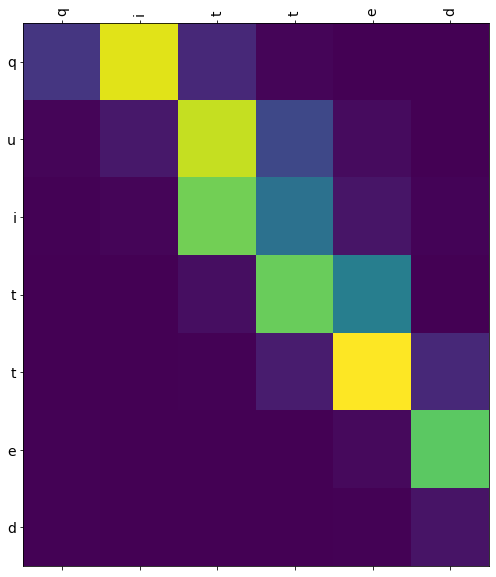

In [81]:
sentence = unigram_train['input'].values[5]
result, attention_plot = predict(sentence, unigram_vec, unigram_index_to_word, gram = 'uni')

print('input : ', sentence)
print('predicted output : ',result)
print('actual output :', unigram_train['output'].values[5])

attention_plot = attention_plot[:len(list(result)), :len(list(sentence))]
plot_attention(attention_plot, list(sentence), list(result))

input :  fortissiemus
predicted output :  fortissimus
actual output : fortissimus


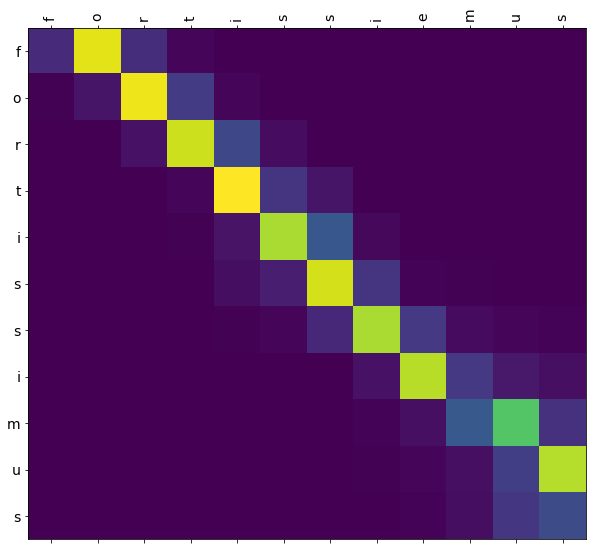

In [82]:
sentence = unigram_train['input'].values[11]
result, attention_plot = predict(sentence, unigram_vec, unigram_index_to_word, gram = 'uni')

print('input : ', sentence)
print('predicted output : ',result)
print('actual output :', unigram_train['output'].values[11])

attention_plot = attention_plot[:len(list(result)), :len(list(sentence))]
plot_attention(attention_plot, list(sentence), list(result))

input: numbeGr
predicted output: number
actual output: number


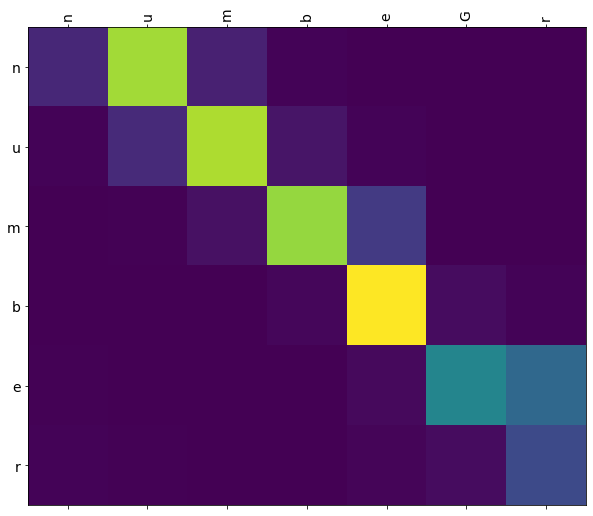

In [83]:
sentence = unigram_train['input'].values[14]
result, attention_plot = predict(sentence, unigram_vec, unigram_index_to_word, gram = 'uni')

print('input:', sentence)
print('predicted output:',result)
print('actual output:', unigram_train['output'].values[14])
attention_plot = attention_plot[:len(list(result)), :len(list(sentence))]
plot_attention(attention_plot, list(sentence), list(result))

In [39]:
val_bleu = 0
for i in tqdm(range(unigram_val.shape[0])):
    inp = unigram_val['input'].values[i]
    out = unigram_val['output'].values[i]
    pred, _ = predict(inp, unigram_vec, unigram_index_to_word, gram = 'uni')
    val_bleu += sentence_bleu([out], pred)

train_bleu = 0
for i in tqdm(range(unigram_train.shape[0])):
    inp = unigram_train['input'].values[i];
    out = unigram_train['output'].values[i]
    pred, _ = predict(inp, unigram_vec, unigram_index_to_word, gram = 'uni')
    train_bleu += sentence_bleu([out], pred)

test_bleu = 0
for i in tqdm(range(unigram_test.shape[0])):
    inp = unigram_test['input'].values[i]
    out = unigram_test['output'].values[i]
    pred, _ = predict(inp, unigram_vec, unigram_index_to_word, gram = 'uni')
    test_bleu += sentence_bleu([out], pred)
    
print('BLEU Score on train: ',train_bleu/unigram_train.shape[0])
print('BLEU Score on val: ',val_bleu/unigram_val.shape[0])
print('BLEU Score on test: ',test_bleu/unigram_test.shape[0])

100%|██████████████████████████████████████████████████████████████████████████████| 3150/3150 [03:06<00:00, 16.88it/s]

BLEU Score on train:  0.8698739128364643
BLEU Score on val:  0.792070857805782
BLEU Score on test:  0.7071433929743683


<h3>2.2 BiGram </h3>

In [83]:
lstm_size = 256
embedding_dim = 100
att_units = 256
maxlen = 26

In [85]:
model = encoder_decoder(vocab_size, vocab_size, embedding_dim, lstm_size, lstm_size, maxlen, maxlen, 'concat', att_units, batch_size)
model.compile(optimizer = 'Adam', loss = loss_function)

callbacks = [ModelCheckpoint('Attention_concat_lstm_bigram.h5', save_best_only= True, verbose = 1),
             EarlyStopping(patience = 5, verbose = 1),
             ReduceLROnPlateau(patience = 3, verbose = 1)]

model.fit(x = bigram_train_dataset, 
          steps_per_epoch = bigram_train.shape[0]//batch_size,
          validation_data = bigram_val_dataset,
          validation_steps = bigram_val.shape[0]//batch_size,
          epochs = 100,
          verbose = 1,
          callbacks = callbacks)

Epoch 1/100
6910/6910 [==============================] - ETA: 0s - loss: 0.8288
Epoch 00001: val_loss improved from inf to 0.06538, saving model to Attention_concat_lstm_bigram.h5
6910/6910 [==============================] - 471s 68ms/step - loss: 0.8288 - val_loss: 0.0654
Epoch 2/100
6910/6910 [==============================] - ETA: 0s - loss: 0.7482
Epoch 00002: val_loss improved from 0.06538 to 0.05269, saving model to Attention_concat_lstm_bigram.h5
6910/6910 [==============================] - 486s 70ms/step - loss: 0.7482 - val_loss: 0.0527
Epoch 3/100
6910/6910 [==============================] - ETA: 0s - loss: 0.7420
Epoch 00003: val_loss improved from 0.05269 to 0.04566, saving model to Attention_concat_lstm_bigram.h5
6910/6910 [==============================] - 498s 72ms/step - loss: 0.7420 - val_loss: 0.0457
Epoch 4/100
6910/6910 [==============================] - ETA: 0s - loss: 0.7379
Epoch 00004: val_loss improved from 0.04566 to 0.04211, saving model to Attention_concat_l

6910/6910 [==============================] - ETA: 0s - loss: 0.7231
Epoch 00031: val_loss did not improve from 0.02620
6910/6910 [==============================] - 472s 68ms/step - loss: 0.7231 - val_loss: 0.0263
Epoch 32/100
6910/6910 [==============================] - ETA: 0s - loss: 0.7230
Epoch 00032: val_loss improved from 0.02620 to 0.02616, saving model to Attention_concat_lstm_bigram.h5
6910/6910 [==============================] - 514s 74ms/step - loss: 0.7230 - val_loss: 0.0262
Epoch 33/100
6910/6910 [==============================] - ETA: 0s - loss: 0.7226
Epoch 00033: val_loss did not improve from 0.02616

Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
6910/6910 [==============================] - 486s 70ms/step - loss: 0.7226 - val_loss: 0.0263
Epoch 34/100
6910/6910 [==============================] - ETA: 0s - loss: 0.7206
Epoch 00034: val_loss improved from 0.02616 to 0.02441, saving model to Attention_concat_lstm_bigram.h5
6910/6910 [====

Epoch 61/100
6910/6910 [==============================] - ETA: 0s - loss: 0.7172
Epoch 00061: val_loss did not improve from 0.02250

Epoch 00061: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
6910/6910 [==============================] - 454s 66ms/step - loss: 0.7172 - val_loss: 0.0225
Epoch 62/100
6910/6910 [==============================] - ETA: 0s - loss: 0.7168
Epoch 00062: val_loss did not improve from 0.02250
6910/6910 [==============================] - 458s 66ms/step - loss: 0.7168 - val_loss: 0.0225
Epoch 63/100
6910/6910 [==============================] - ETA: 0s - loss: 0.7165
Epoch 00063: val_loss did not improve from 0.02250
6910/6910 [==============================] - 459s 66ms/step - loss: 0.7165 - val_loss: 0.0225
Epoch 64/100
6910/6910 [==============================] - ETA: 0s - loss: 0.7171
Epoch 00064: val_loss did not improve from 0.02250

Epoch 00064: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
6910/6910 [================

In [87]:
pred_model = pred_Encoder_decoder(vocab_size, vocab_size, embedding_dim, lstm_size, lstm_size, maxlen, maxlen, 'concat', att_units, bigram_word_to_index)
pred_model.compile(optimizer = 'Adam', loss = loss_function)
pred_model.build(input_shape= (None, 1, maxlen))
pred_model.load_weights('Attention_concat_lstm_bigram.h5')

input :  no Lne
predicted output :  no one
actual output : no one


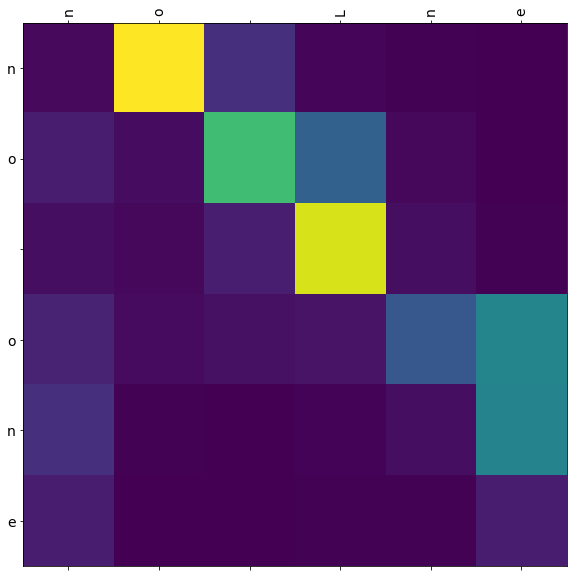

In [88]:
sentence = bigram_train['input'].values[4]
result, attention_plot = predict(sentence, bigram_vec, bigram_index_to_word, gram = 'bi')

print('input : ', sentence)
print('predicted output : ',result)
print('actual output :', bigram_train['output'].values[4])

attention_plot = attention_plot[:len(list(result)), :len(list(sentence))]
plot_attention(attention_plot, list(sentence), list(result))

input :  for themseves
predicted output :  for themselves
actual output : for themselves


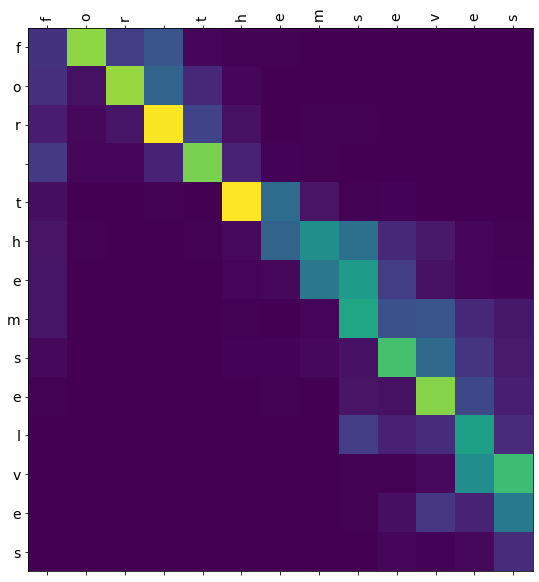

In [89]:
sentence = bigram_train['input'].values[6]
result, attention_plot = predict(sentence, bigram_vec, bigram_index_to_word, gram = 'bi')

print('input : ', sentence)
print('predicted output : ',result)
print('actual output :', bigram_train['output'].values[6])

attention_plot = attention_plot[:len(list(result)), :len(list(sentence))]
plot_attention(attention_plot, list(sentence), list(result))

input :  detil of
predicted output :  detail of
actual output : detail of


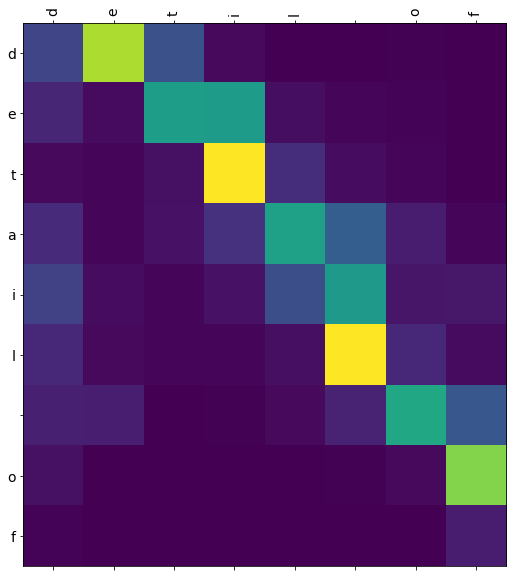

In [90]:
sentence = bigram_train['input'].values[7]
result, attention_plot = predict(sentence, bigram_vec, bigram_index_to_word, gram = 'bi')

print('input : ', sentence)
print('predicted output : ',result)
print('actual output :', bigram_train['output'].values[7])

attention_plot = attention_plot[:len(list(result)), :len(list(sentence))]
plot_attention(attention_plot, list(sentence), list(result))

In [ ]:
val_bleu = 0
for i in tqdm(range(bigram_val.shape[0])):
    inp = bigram_val['input'].values[i]
    out = bigram_val['output'].values[i]
    pred, _ = predict(inp, bigram_vec, bigram_index_to_word, gram = 'bi')
    val_bleu += sentence_bleu([out], pred)

train_bleu = 0
for i in tqdm(range(bigram_train.shape[0])):
    inp = bigram_train['input'].values[i];
    out = bigram_train['output'].values[i]
    pred, _ = predict(inp, bigram_vec, bigram_index_to_word, gram = 'bi')
    train_bleu += sentence_bleu([out], pred)

test_bleu = 0
for i in tqdm(range(bigram_test.shape[0])):
    inp = bigram_test['input'].values[i]
    out = bigram_test['output'].values[i]
    pred, _ = predict(inp, bigram_vec, bigram_index_to_word, gram = 'bi')
    test_bleu += sentence_bleu([out], pred)
    
print('BLEU Score on train: ',train_bleu/bigram_train.shape[0])
print('BLEU Score on val: ',val_bleu/bigram_val.shape[0])
print('BLEU Score on test: ',test_bleu/bigram_test.shape[0])

<h3>2.3 TriGram </h3>

In [91]:
lstm_size = 256
embedding_dim = 100
att_units = 256
maxlen = 34

In [92]:
model = encoder_decoder(vocab_size, vocab_size, embedding_dim, lstm_size, lstm_size, maxlen, maxlen, 'concat', att_units, batch_size)
model.compile(optimizer = 'Adam', loss = loss_function)

callbacks = [ModelCheckpoint('Attention_concat_lstm_trigram.h5', save_best_only= True, verbose = 1),
             EarlyStopping(patience = 5, verbose = 1),
             ReduceLROnPlateau(patience = 3, verbose = 1)]

model.fit(x = trigram_train_dataset, 
          steps_per_epoch = trigram_train.shape[0]//batch_size,
          validation_data = trigram_val_dataset,
          validation_steps = trigram_val.shape[0]//batch_size,
          epochs = 100,
          verbose = 1,
          callbacks = callbacks)

Epoch 1/100
6910/6910 [==============================] - ETA: 0s - loss: 0.9333
Epoch 00001: val_loss improved from inf to 0.05902, saving model to Attention_concat_lstm_trigram.h5
6910/6910 [==============================] - 619s 90ms/step - loss: 0.9333 - val_loss: 0.0590
Epoch 2/100
6910/6910 [==============================] - ETA: 0s - loss: 0.8491
Epoch 00002: val_loss improved from 0.05902 to 0.04622, saving model to Attention_concat_lstm_trigram.h5
6910/6910 [==============================] - 622s 90ms/step - loss: 0.8491 - val_loss: 0.0462
Epoch 3/100
6910/6910 [==============================] - ETA: 0s - loss: 0.8422
Epoch 00003: val_loss improved from 0.04622 to 0.04152, saving model to Attention_concat_lstm_trigram.h5
6910/6910 [==============================] - 625s 90ms/step - loss: 0.8422 - val_loss: 0.0415
Epoch 4/100
6910/6910 [==============================] - ETA: 0s - loss: 0.8382
Epoch 00004: val_loss improved from 0.04152 to 0.03638, saving model to Attention_conca

6910/6910 [==============================] - ETA: 0s - loss: 0.8247
Epoch 00031: val_loss did not improve from 0.02219

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
6910/6910 [==============================] - 645s 93ms/step - loss: 0.8247 - val_loss: 0.0227
Epoch 32/100
6910/6910 [==============================] - ETA: 0s - loss: 0.8227
Epoch 00032: val_loss improved from 0.02219 to 0.02104, saving model to Attention_concat_lstm_trigram.h5
6910/6910 [==============================] - 660s 96ms/step - loss: 0.8227 - val_loss: 0.0210
Epoch 33/100
6910/6910 [==============================] - ETA: 0s - loss: 0.8221
Epoch 00033: val_loss improved from 0.02104 to 0.02061, saving model to Attention_concat_lstm_trigram.h5
6910/6910 [==============================] - 679s 98ms/step - loss: 0.8221 - val_loss: 0.0206
Epoch 34/100
6910/6910 [==============================] - ETA: 0s - loss: 0.8214
Epoch 00034: val_loss improved from 0.02061 to 0.02026, saving m

6910/6910 [==============================] - ETA: 0s - loss: 0.8188
Epoch 00061: val_loss improved from 0.01860 to 0.01858, saving model to Attention_concat_lstm_trigram.h5
6910/6910 [==============================] - 673s 97ms/step - loss: 0.8188 - val_loss: 0.0186
Epoch 62/100
6910/6910 [==============================] - ETA: 0s - loss: 0.8192
Epoch 00062: val_loss improved from 0.01858 to 0.01857, saving model to Attention_concat_lstm_trigram.h5

Epoch 00062: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
6910/6910 [==============================] - 684s 99ms/step - loss: 0.8192 - val_loss: 0.0186
Epoch 63/100
6910/6910 [==============================] - ETA: 0s - loss: 0.8191
Epoch 00063: val_loss improved from 0.01857 to 0.01856, saving model to Attention_concat_lstm_trigram.h5
6910/6910 [==============================] - 650s 94ms/step - loss: 0.8191 - val_loss: 0.0186
Epoch 64/100
6910/6910 [==============================] - ETA: 0s - loss: 0.8191
Epoch 0006

In [93]:
pred_model = pred_Encoder_decoder(vocab_size, vocab_size, embedding_dim, lstm_size, lstm_size, maxlen, maxlen, 'concat', att_units, trigram_word_to_index)
pred_model.compile(optimizer = 'Adam', loss = loss_function)
pred_model.build(input_shape= (None, 1, maxlen))
pred_model.load_weights('Attention_concat_lstm_trigram.h5')

input :  woman oAf him
predicted output :  woman of him
actual output : woman of him


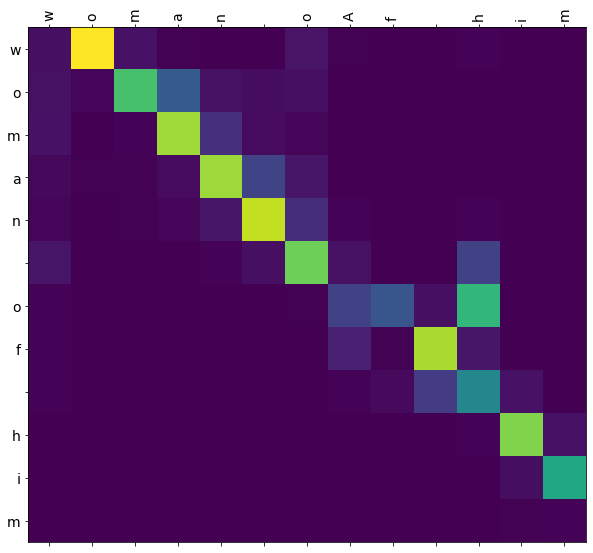

In [97]:
sentence = trigram_train['input'].values[4]
result, attention_plot = predict(sentence, trigram_vec, trigram_index_to_word, gram = 'tri')

print('input : ', sentence)
print('predicted output : ',result)
print('actual output :', trigram_train['output'].values[4])

attention_plot = attention_plot[:len(list(result)), :len(list(sentence))]
plot_attention(attention_plot, list(sentence), list(result))

input :  endurXe a collision
predicted output :  endure a collision
actual output : endure a collision


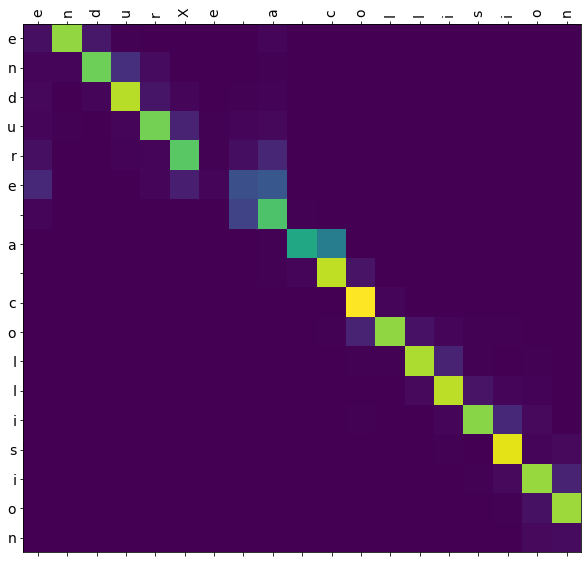

In [98]:
sentence = trigram_train['input'].values[7]
result, attention_plot = predict(sentence, trigram_vec, trigram_index_to_word, gram = 'tri')

print('input : ', sentence)
print('predicted output : ',result)
print('actual output :', trigram_train['output'].values[7])

attention_plot = attention_plot[:len(list(result)), :len(list(sentence))]
plot_attention(attention_plot, list(sentence), list(result))

input :  marshals sitti g on
predicted output :  marshals sitting on
actual output : marshals sitting on


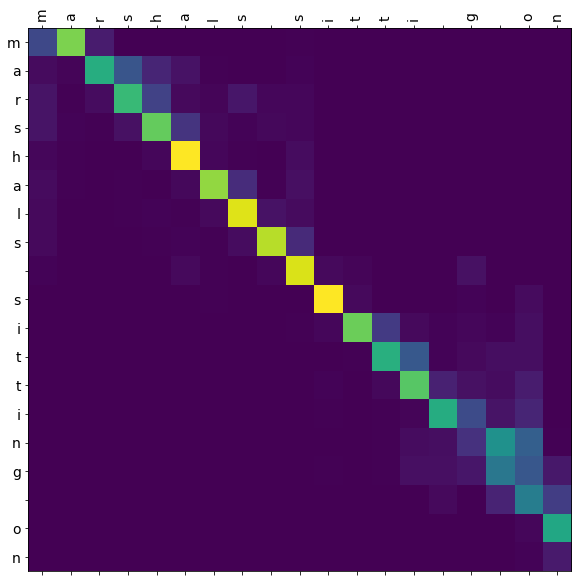

In [99]:
sentence = trigram_train['input'].values[10]
result, attention_plot = predict(sentence, trigram_vec, trigram_index_to_word, gram = 'tri')

print('input : ', sentence)
print('predicted output : ',result)
print('actual output :', trigram_train['output'].values[10])

attention_plot = attention_plot[:len(list(result)), :len(list(sentence))]
plot_attention(attention_plot, list(sentence), list(result))

In [ ]:
val_bleu = 0
for i in tqdm(range(trigram_val.shape[0])):
    inp = trigram_val['input'].values[i]
    out = trigram_val['output'].values[i]
    pred, _ = predict(inp, trigram_vec, trigram_index_to_word, gram = 'tri')
    val_bleu += sentence_bleu([out], pred)

train_bleu = 0
for i in tqdm(range(trigram_train.shape[0])):
    inp = trigram_train['input'].values[i];
    out = trigram_train['output'].values[i]
    pred, _ = predict(inp, trigram_vec, trigram_index_to_word, gram = 'tri')
    train_bleu += sentence_bleu([out], pred)

test_bleu = 0
for i in tqdm(range(trigram_test.shape[0])):
    inp = trigram_test['input'].values[i]
    out = trigram_test['output'].values[i]
    pred, _ = predict(inp, trigram_vec, trigram_index_to_word, gram = 'tri')
    test_bleu += sentence_bleu([out], pred)
    
print('BLEU Score on train: ',train_bleu/trigram_train.shape[0])
print('BLEU Score on val: ',val_bleu/trigram_val.shape[0])
print('BLEU Score on test: ',test_bleu/trigram_test.shape[0])

<h2>3. Seq2Seq Bi-LSTM with Attention Mechanism</h2>

In [106]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_size, lstm_size, input_length):
        super(Encoder, self).__init__()
        self.lstm_size = lstm_size
        self.enc_embed = Embedding(input_dim = vocab_size, output_dim = embedding_size)
        self.enc_lstm = Bidirectional(LSTM(lstm_size, return_sequences = True, return_state = True, dropout = 0.4))
    
    def call(self, input_sequence, states):
        embedding = self.enc_embed(input_sequence)
        output_state, enc_frwd_h, enc_frwd_c, enc_bkwd_h, enc_bkwd_c = self.enc_lstm(embedding, initial_state = states)
        return output_state, enc_frwd_h, enc_frwd_c, enc_bkwd_h, enc_bkwd_c
    
    def initialize_states(self, batch_size):
        return [tf.zeros((batch_size, self.lstm_size)), tf.zeros((batch_size, self.lstm_size)),
                tf.zeros((batch_size, self.lstm_size)), tf.zeros((batch_size, self.lstm_size))]

class Attention(tf.keras.layers.Layer):
    def __init__(self,scoring_function, att_units):
        super(Attention, self).__init__()
        self.scoring_function = scoring_function
        if scoring_function == 'dot':
            self.dot = Dot(axes = (1, 2))
        elif scoring_function == 'general':
            self.W = Dense(att_units)
            self.dot = Dot(axes = (1, 2))
        elif scoring_function == 'concat':
            self.W1 = Dense(att_units)
            self.W2 = Dense(att_units)
            self.W3 = Dense(att_units)
            self.V = Dense(1)
            
    def call(self, dec_frwd_state, dec_bkwd_state, encoder_output):
        dec_frwd_state = tf.expand_dims(dec_frwd_state, 1) 
        dec_bkwd_state = tf.expand_dims(dec_bkwd_state, 1)
#         
        if self.scoring_function == 'dot':
            score = tf.transpose(self.dot([tf.transpose(decoder_hidden_state, (0, 2, 1)), encoder_output]), (0, 2,1))           
        elif self.scoring_function == 'general':
            mul = self.W(encoder_output)
            score = tf.transpose(self.dot([tf.transpose(decoder_hidden_state, (0, 2, 1)), mul]), (0, 2,1))           
        elif self.scoring_function == 'concat':
            inter = self.W1(dec_frwd_state) + self.W2(dec_bkwd_state) + self.W3(encoder_output)
            tan = tf.nn.tanh(inter)
            score = self.V(tan)
        attention_weights = tf.nn.softmax(score, axis =1)
        context_vector = attention_weights * encoder_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

class OneStepDecoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        super(OneStepDecoder, self).__init__()
      # Initialize decoder embedding layer, LSTM and any other objects needed
        self.embed_dec = Embedding(input_dim = vocab_size, output_dim = embedding_dim)
        self.lstm = Bidirectional(LSTM(dec_units, return_sequences = True, return_state = True, dropout = 0.4))
        self.attention = Attention(scoring_function = score_fun, att_units = att_units)
        self.fc = Dense(vocab_size)
    
    def call(self,input_to_decoder, encoder_output, state_frwd_h, state_frwd_c, state_bkwd_h, state_bkwd_c):
        embed = self.embed_dec(input_to_decoder)
        context_vect, attention_weights = self.attention(state_frwd_h, state_bkwd_h, encoder_output)    
        final_inp = tf.concat([tf.expand_dims(context_vect, 1), embed], axis = -1)
        out, dec_frwd_h, dec_frwd_c, dec_bkwd_h, dec_bkwd_c = self.lstm(final_inp, [state_frwd_h, state_frwd_c, state_bkwd_h, state_bkwd_c])
        out = tf.reshape(out, (-1, out.shape[2]))
        out = Dropout(0.5)(out)
        output = self.fc(out)
        return output, dec_frwd_h, dec_frwd_c, dec_bkwd_h, dec_bkwd_c, attention_weights, context_vect

class encoder_decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, dec_units, max_len, score_fun, att_units, batch_size):
        #Intialize objects from encoder decoder
        super(encoder_decoder, self).__init__()
        self.encoder = Encoder(vocab_size, embedding_dim, enc_units, max_len)
        self.one_step_decoder = OneStepDecoder(vocab_size, embedding_dim, max_len, dec_units ,score_fun ,att_units)
        self.batch_size = batch_size
    
    def call(self, data):
        enc_inp, dec_inp = data[0], data[1]
        initial_state = self.encoder.initialize_states(self.batch_size)
        enc_output, enc_frwd_h, enc_frwd_c, enc_bkwd_h, enc_bkwd_c = self.encoder(enc_inp, initial_state)
        all_outputs = tf.TensorArray(dtype = tf.float32, size= max_len)
        
        dec_frwd_h = enc_frwd_h
        dec_frwd_c = enc_frwd_c
        dec_bkwd_h = enc_bkwd_h
        dec_bkwd_c = enc_bkwd_c
        for timestep in range(max_len):
            # Call onestepdecoder for each token in decoder_input
            output, dec_frwd_h, dec_frwd_c, dec_bkwd_h, dec_bkwd_c, _, _ = self.one_step_decoder(dec_inp[:, timestep:timestep+1], enc_output, dec_frwd_h, dec_frwd_c, dec_bkwd_h, dec_bkwd_c)
            # Store the output in tensorarray
            all_outputs = all_outputs.write(timestep, output)
        # Return the tensor array
        all_outputs = tf.transpose(all_outputs.stack(), (1, 0, 2))
        # return the decoder output
        return all_outputs
    
class pred_Encoder_decoder(tf.keras.Model): 
    def __init__(self, inp_vocab_size, out_vocab_size, embedding_dim, enc_units, dec_units, max_len_ita, max_len_eng, score_fun, att_units, word_to_index):
        #Intialize objects from encoder decoder
        super(pred_Encoder_decoder, self).__init__()
        self.encoder = Encoder(inp_vocab_size, embedding_dim, enc_units, max_len_ita)
        self.one_step_decoder = OneStepDecoder(out_vocab_size, embedding_dim, max_len_eng, dec_units, score_fun, att_units)
        self.word_to_index = word_to_index
        
    def call(self, params):
        enc_inp = params[0]
        initial_state = self.encoder.initialize_states(1)
        enc_output, enc_frwd_h, enc_frwd_c, enc_bkwd_h, enc_bkwd_c = self.encoder(enc_inp, initial_state)
        pred = tf.expand_dims([self.word_to_index['<SOW>']], 0)
        all_pred = []
        all_attention = []

        dec_frwd_h = enc_frwd_h
        dec_frwd_c = enc_frwd_c
        dec_bkwd_h = enc_bkwd_h
        dec_bkwd_c = enc_bkwd_c
        for timestep in range(max_len):
            # Call onestepdecoder for each token in decoder_input
            output, dec_frwd_h, dec_frwd_c, dec_bkwd_h, dec_bkwd_c, attention, _ = self.one_step_decoder(pred, enc_output, dec_frwd_h, dec_frwd_c, dec_bkwd_h, dec_bkwd_c)
            pred = tf.argmax(output, axis = -1)
            all_pred.append(pred)
            pred = tf.expand_dims(pred, 0)
            all_attention.append(attention)

        return all_pred, all_attention

<h3>3.1 UniGram</h3>

In [ ]:
lstm_size = 256
embedding_dim = 100
att_units = 256
maxlen = 22

In [41]:
model = encoder_decoder(vocab_size, embedding_dim, lstm_size, lstm_size, maxlen, 'concat', att_units, batch_size)
model.compile(optimizer = 'Adam', loss = loss_function)

callbacks = [ModelCheckpoint('concat_best.h5', save_best_only= True, verbose = 1),
             EarlyStopping(patience = 5, verbose = 1),
             ReduceLROnPlateau(patience = 3, verbose = 1)]

model.fit(x = unigram_train_dataset, 
          steps_per_epoch = unigram_train.shape[0]//batch_size,
          validation_data = unigram_val_dataset,
          validation_steps = unigram_val.shape[0]//batch_size,
          epochs = 50,
          verbose = 1,
          callbacks = callbacks)

Epoch 1/50
258/258 [==============================] - ETA: 0s - loss: 0.9726
Epoch 00001: val_loss improved from inf to 0.53295, saving model to concat_best.h5
258/258 [==============================] - 33s 127ms/step - loss: 0.9726 - val_loss: 0.5329
Epoch 2/50
258/258 [==============================] - ETA: 0s - loss: 0.3148
Epoch 00002: val_loss improved from 0.53295 to 0.16296, saving model to concat_best.h5
258/258 [==============================] - 23s 89ms/step - loss: 0.3148 - val_loss: 0.1630
Epoch 3/50
258/258 [==============================] - ETA: 0s - loss: 0.1810
Epoch 00003: val_loss improved from 0.16296 to 0.13154, saving model to concat_best.h5
258/258 [==============================] - 24s 91ms/step - loss: 0.1810 - val_loss: 0.1315
Epoch 4/50
258/258 [==============================] - ETA: 0s - loss: 0.1521
Epoch 00004: val_loss improved from 0.13154 to 0.12262, saving model to concat_best.h5
258/258 [==============================] - 24s 93ms/step - loss: 0.1521 - 

In [43]:
pred_model = pred_Encoder_decoder(vocab_size, vocab_size, embedding_dim, lstm_size, lstm_size, max_len, max_len, 'concat', att_units)
pred_model.compile(optimizer = 'Adam', loss = loss_function)
pred_model.build(input_shape= (None, 1, maxlen))
pred_model.load_weights('concat_best.h5')

input: qitted
predicted output: quitted
actual output: quitted


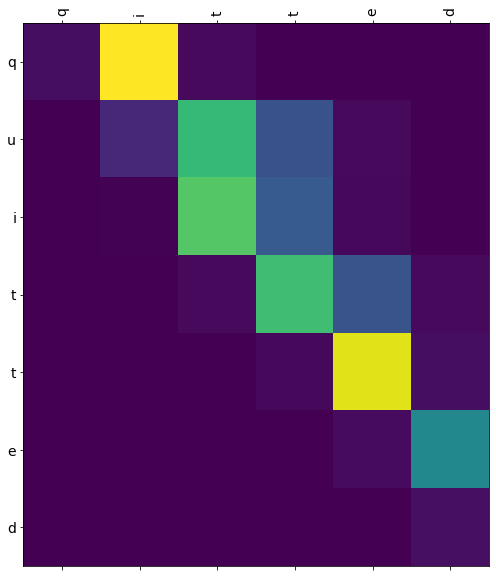

In [54]:
sentence = unigram_train['input'].values[5]
result, attention_plot = predict(sentence, unigram_vec, unigram_index_to_word, gram = 'uni')

print('input : ', sentence)
print('predicted output : ',result)
print('actual output :', unigram_train['output'].values[5])

attention_plot = attention_plot[:len(list(result)), :len(list(sentence))]
plot_attention(attention_plot, list(sentence), list(result))

input: fortissiemus
predicted output: fortissimus
actual output: fortissimus


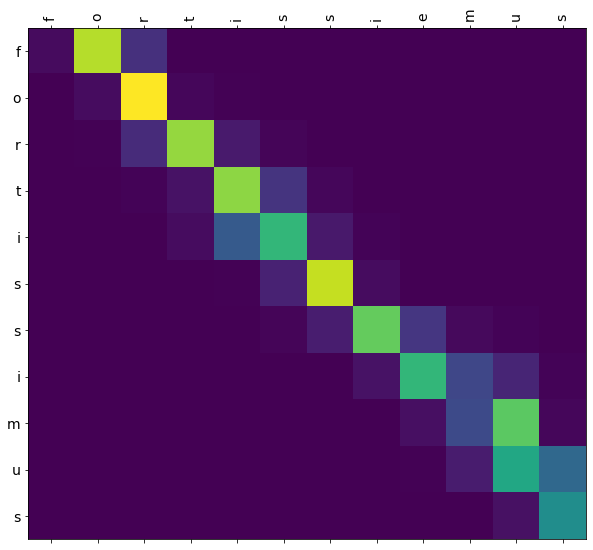

In [61]:
sentence = unigram_train['input'].values[11]
result, attention_plot = predict(sentence, unigram_vec, unigram_index_to_word, gram = 'uni')

print('input : ', sentence)
print('predicted output : ',result)
print('actual output :', unigram_train['output'].values[11])

attention_plot = attention_plot[:len(list(result)), :len(list(sentence))]
plot_attention(attention_plot, list(sentence), list(result))

input: numbeGr
predicted output: number
actual output: number


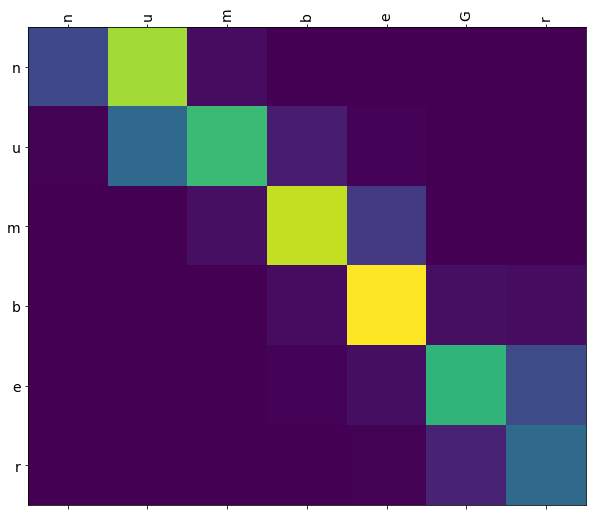

In [65]:
sentence = unigram_train['input'].values[14]
result, attention_plot = predict(sentence, unigram_vec, unigram_index_to_word, gram = 'uni')

print('input : ', sentence)
print('predicted output : ',result)
print('actual output :', unigram_train['output'].values[14])

attention_plot = attention_plot[:len(list(result)), :len(list(sentence))]
plot_attention(attention_plot, list(sentence), list(result))

In [47]:
val_bleu = 0
for i in tqdm(range(unigram_val.shape[0])):
    inp = unigram_val['input'].values[i]
    out = unigram_val['output'].values[i]
    pred, _ = predict(inp, unigram_vec, unigram_index_to_word, gram = 'uni')
    val_bleu += sentence_bleu([out], pred)

train_bleu = 0
for i in tqdm(range(unigram_train.shape[0])):
    inp = unigram_train['input'].values[i];
    out = unigram_train['output'].values[i]
    pred, _ = predict(inp, unigram_vec, unigram_index_to_word, gram = 'uni')
    train_bleu += sentence_bleu([out], pred)

test_bleu = 0
for i in tqdm(range(unigram_test.shape[0])):
    inp = unigram_test['input'].values[i]
    out = unigram_test['output'].values[i]
    pred, _ = predict(inp, unigram_vec, unigram_index_to_word, gram = 'uni')
    test_bleu += sentence_bleu([out], pred)
    
print('BLEU Score on train: ',train_bleu/unigram_train.shape[0])
print('BLEU Score on val: ',val_bleu/unigram_val.shape[0])
print('BLEU Score on test: ',test_bleu/unigram_test.shape[0])

100%|██████████████████████████████████████████████████████████████████████████████| 3150/3150 [03:38<00:00, 14.41it/s]

BLEU Score on train:  0.8553528187207379
BLEU Score on val:  0.8027546198959468
BLEU Score on test:  0.712202060966304


<h3>3.2 BiGram </h3>

In [107]:
lstm_size = 256
embedding_dim = 100
att_units = 256
maxlen = 26

In [104]:
model = encoder_decoder(vocab_size, embedding_dim, lstm_size, lstm_size, maxlen, 'concat', att_units, batch_size)
model.compile(optimizer = 'Adam', loss = loss_function)

callbacks = [ModelCheckpoint('concat_best_bigram.h5', save_best_only= True, verbose = 1),
             EarlyStopping(patience = 5, verbose = 1),
             ReduceLROnPlateau(patience = 3, verbose = 1)]

model.fit(x = bigram_train_dataset, 
          steps_per_epoch = bigram_train.shape[0]//batch_size,
          validation_data = bigram_val_dataset,
          validation_steps = bigram_val.shape[0]//batch_size,
          epochs = 100,
          verbose = 1,
          callbacks = callbacks)

Epoch 1/100
6910/6910 [==============================] - ETA: 0s - loss: 0.1299
Epoch 00001: val_loss improved from inf to 0.04310, saving model to concat_best_bigram.h5
6910/6910 [==============================] - 847s 123ms/step - loss: 0.1299 - val_loss: 0.0431
Epoch 2/100
6910/6910 [==============================] - ETA: 0s - loss: 0.0464
Epoch 00002: val_loss improved from 0.04310 to 0.03256, saving model to concat_best_bigram.h5
6910/6910 [==============================] - 869s 126ms/step - loss: 0.0464 - val_loss: 0.0326
Epoch 3/100
6910/6910 [==============================] - ETA: 0s - loss: 0.0377
Epoch 00003: val_loss improved from 0.03256 to 0.02836, saving model to concat_best_bigram.h5
6910/6910 [==============================] - 878s 127ms/step - loss: 0.0377 - val_loss: 0.0284
Epoch 4/100
6910/6910 [==============================] - ETA: 0s - loss: 0.0334
Epoch 00004: val_loss improved from 0.02836 to 0.02540, saving model to concat_best_bigram.h5
6910/6910 [============

6910/6910 [==============================] - ETA: 0s - loss: 0.0134
Epoch 00032: val_loss did not improve from 0.01773
6910/6910 [==============================] - 829s 120ms/step - loss: 0.0134 - val_loss: 0.0178
Epoch 33/100
6910/6910 [==============================] - ETA: 0s - loss: 0.0132
Epoch 00033: val_loss did not improve from 0.01773
6910/6910 [==============================] - 820s 119ms/step - loss: 0.0132 - val_loss: 0.0178
Epoch 34/100
6910/6910 [==============================] - ETA: 0s - loss: 0.0130
Epoch 00034: val_loss did not improve from 0.01773

Epoch 00034: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
6910/6910 [==============================] - 820s 119ms/step - loss: 0.0130 - val_loss: 0.0178
Epoch 35/100
6910/6910 [==============================] - ETA: 0s - loss: 0.0127
Epoch 00035: val_loss did not improve from 0.01773
6910/6910 [==============================] - 819s 119ms/step - loss: 0.0127 - val_loss: 0.0178
Epoch 36/100
6910/6910 

In [108]:
pred_model = pred_Encoder_decoder(vocab_size, vocab_size, embedding_dim, lstm_size, lstm_size, maxlen, maxlen, 'concat', att_units, bigram_word_to_index)
pred_model.compile(optimizer = 'Adam', loss = loss_function)
pred_model.build(input_shape= (None, 1, maxlen))
pred_model.load_weights('concat_best_bigram.h5')

input :  no Lne
predicted output :  no one
actual output : no one


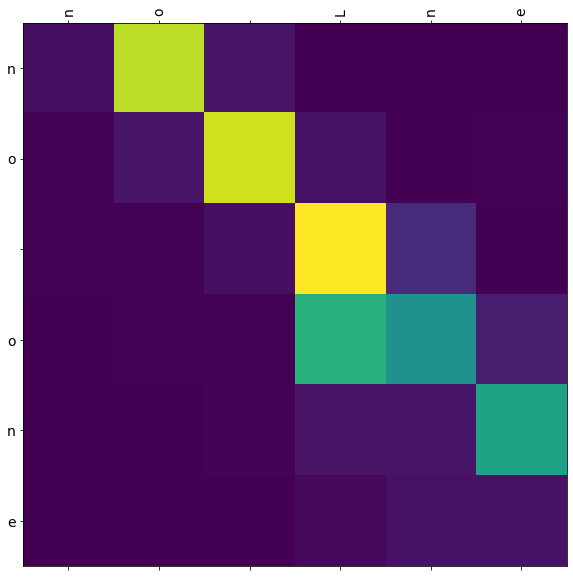

In [109]:
sentence = bigram_train['input'].values[4]
result, attention_plot = predict(sentence, bigram_vec, bigram_index_to_word, gram = 'bi')

print('input : ', sentence)
print('predicted output : ',result)
print('actual output :', bigram_train['output'].values[4])

attention_plot = attention_plot[:len(list(result)), :len(list(sentence))]
plot_attention(attention_plot, list(sentence), list(result))

input :  for themseves
predicted output :  for themselves
actual output : for themselves


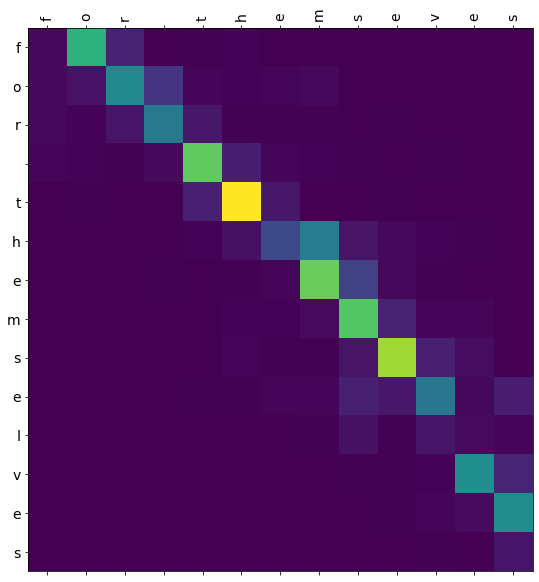

In [110]:
sentence = bigram_train['input'].values[6]
result, attention_plot = predict(sentence, bigram_vec, bigram_index_to_word, gram = 'bi')

print('input : ', sentence)
print('predicted output : ',result)
print('actual output :', bigram_train['output'].values[6])

attention_plot = attention_plot[:len(list(result)), :len(list(sentence))]
plot_attention(attention_plot, list(sentence), list(result))

input :  detil of
predicted output :  detail of
actual output : detail of


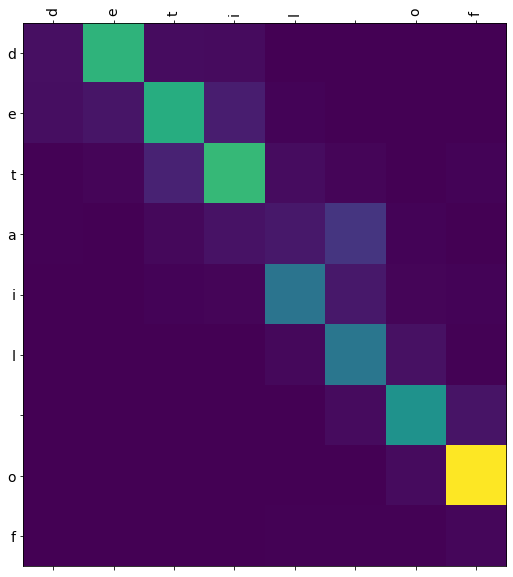

In [111]:
sentence = bigram_train['input'].values[7]
result, attention_plot = predict(sentence, bigram_vec, bigram_index_to_word, gram = 'bi')

print('input : ', sentence)
print('predicted output : ',result)
print('actual output :', bigram_train['output'].values[7])

attention_plot = attention_plot[:len(list(result)), :len(list(sentence))]
plot_attention(attention_plot, list(sentence), list(result))

In [ ]:
val_bleu = 0
for i in tqdm(range(bigram_val.shape[0])):
    inp = bigram_val['input'].values[i]
    out = bigram_val['output'].values[i]
    pred, _ = predict(inp, bigram_vec, bigram_index_to_word, gram = 'bi')
    val_bleu += sentence_bleu([out], pred)

train_bleu = 0
for i in tqdm(range(bigram_train.shape[0])):
    inp = bigram_train['input'].values[i];
    out = bigram_train['output'].values[i]
    pred, _ = predict(inp, bigram_vec, bigram_index_to_word, gram = 'bi')
    train_bleu += sentence_bleu([out], pred)

test_bleu = 0
for i in tqdm(range(bigram_test.shape[0])):
    inp = bigram_test['input'].values[i]
    out = bigram_test['output'].values[i]
    pred, _ = predict(inp, bigram_vec, bigram_index_to_word, gram = 'bi')
    test_bleu += sentence_bleu([out], pred)
    
print('BLEU Score on train: ',train_bleu/bigram_train.shape[0])
print('BLEU Score on val: ',val_bleu/bigram_val.shape[0])
print('BLEU Score on test: ',test_bleu/bigram_test.shape[0])

<h3>3.3 TriGram</h3>

In [112]:
lstm_size = 256
embedding_dim = 100
att_units = 256
maxlen = 34

In [114]:
model = encoder_decoder(vocab_size, embedding_dim, lstm_size, lstm_size, maxlen, 'concat', att_units, batch_size)
model.compile(optimizer = 'Adam', loss = loss_function)


callbacks = [ModelCheckpoint('concat_best_trigram.h5', save_best_only= True, verbose = 1),
             EarlyStopping(patience = 5, verbose = 1),
             ReduceLROnPlateau(patience = 3, verbose = 1)]

model.fit(x = trigram_train_dataset, 
          steps_per_epoch = trigram_train.shape[0]//batch_size,
          validation_data = trigram_val_dataset,
          validation_steps = trigram_val.shape[0]//batch_size,
          epochs = 100,
          verbose = 1,
          callbacks = callbacks)

Epoch 1/100
6910/6910 [==============================] - ETA: 0s - loss: 0.1372
Epoch 00001: val_loss improved from inf to 0.04223, saving model to concat_best_trigram.h5
6910/6910 [==============================] - 1156s 167ms/step - loss: 0.1372 - val_loss: 0.0422
Epoch 2/100
6910/6910 [==============================] - ETA: 0s - loss: 0.0439
Epoch 00002: val_loss improved from 0.04223 to 0.03123, saving model to concat_best_trigram.h5
6910/6910 [==============================] - 1154s 167ms/step - loss: 0.0439 - val_loss: 0.0312
Epoch 3/100
6910/6910 [==============================] - ETA: 0s - loss: 0.0349
Epoch 00003: val_loss improved from 0.03123 to 0.02453, saving model to concat_best_trigram.h5
6910/6910 [==============================] - 1158s 168ms/step - loss: 0.0349 - val_loss: 0.0245
Epoch 4/100
6910/6910 [==============================] - ETA: 0s - loss: 0.0303
Epoch 00004: val_loss improved from 0.02453 to 0.02350, saving model to concat_best_trigram.h5
6910/6910 [=====

6910/6910 [==============================] - ETA: 0s - loss: 0.0117
Epoch 00031: val_loss improved from 0.01366 to 0.01364, saving model to concat_best_trigram.h5
6910/6910 [==============================] - 1326s 192ms/step - loss: 0.0117 - val_loss: 0.0136
Epoch 32/100
6910/6910 [==============================] - ETA: 0s - loss: 0.0116
Epoch 00032: val_loss did not improve from 0.01364
6910/6910 [==============================] - 1265s 183ms/step - loss: 0.0116 - val_loss: 0.0136
Epoch 33/100
6910/6910 [==============================] - ETA: 0s - loss: 0.0114
Epoch 00033: val_loss improved from 0.01364 to 0.01358, saving model to concat_best_trigram.h5
6910/6910 [==============================] - 1266s 183ms/step - loss: 0.0114 - val_loss: 0.0136
Epoch 34/100
6910/6910 [==============================] - ETA: 0s - loss: 0.0113
Epoch 00034: val_loss improved from 0.01358 to 0.01357, saving model to concat_best_trigram.h5

Epoch 00034: ReduceLROnPlateau reducing learning rate to 1.00000

In [115]:
pred_model = pred_Encoder_decoder(vocab_size, vocab_size, embedding_dim, lstm_size, lstm_size, maxlen, maxlen, 'concat', att_units, trigram_word_to_index)
pred_model.compile(optimizer = 'Adam', loss = loss_function)
pred_model.build(input_shape= (None, 1, maxlen))
pred_model.load_weights('concat_best_trigram.h5')

input :  woman oAf him
predicted output :  woman of him
actual output : woman of him


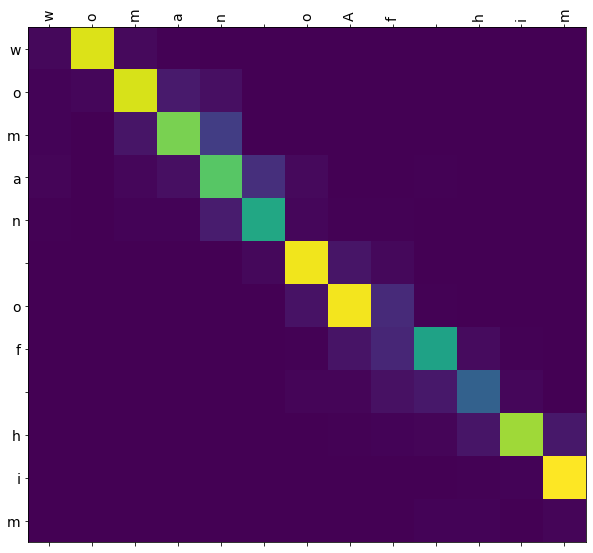

In [116]:
sentence = trigram_train['input'].values[4]
result, attention_plot = predict(sentence, trigram_vec, trigram_index_to_word, gram = 'tri')

print('input : ', sentence)
print('predicted output : ',result)
print('actual output :', trigram_train['output'].values[4])

attention_plot = attention_plot[:len(list(result)), :len(list(sentence))]
plot_attention(attention_plot, list(sentence), list(result))

input :  endurXe a collision
predicted output :  endure a collision
actual output : endure a collision


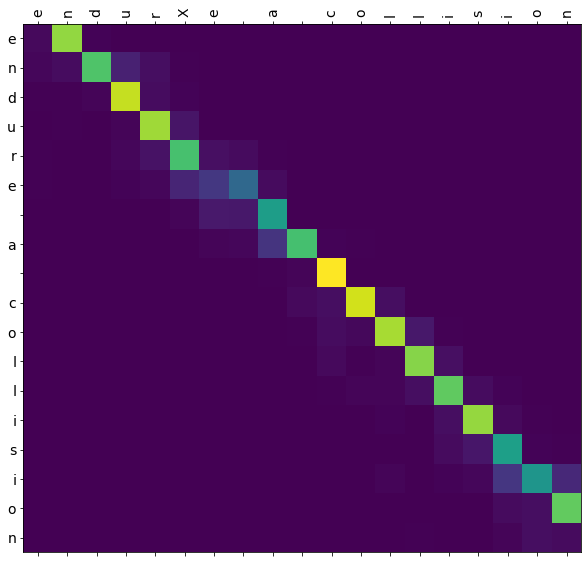

In [117]:
sentence = trigram_train['input'].values[7]
result, attention_plot = predict(sentence, trigram_vec, trigram_index_to_word, gram = 'tri')

print('input : ', sentence)
print('predicted output : ',result)
print('actual output :', trigram_train['output'].values[7])

attention_plot = attention_plot[:len(list(result)), :len(list(sentence))]
plot_attention(attention_plot, list(sentence), list(result))

input :  marshals sitti g on
predicted output :  marshals sitting on
actual output : marshals sitting on


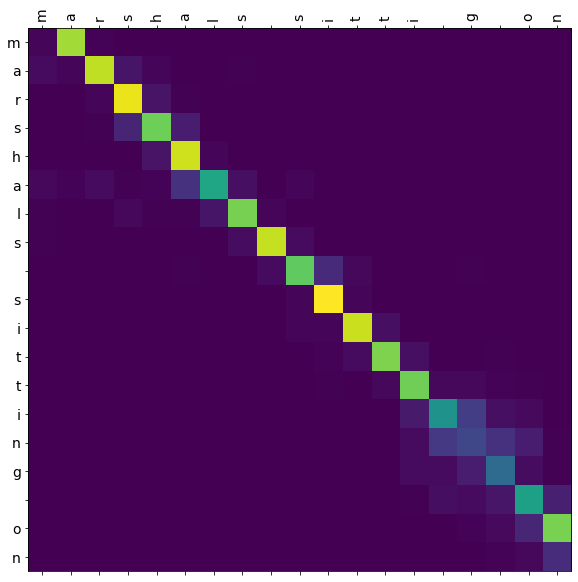

In [118]:
sentence = trigram_train['input'].values[10]
result, attention_plot = predict(sentence, trigram_vec, trigram_index_to_word, gram = 'tri')

print('input : ', sentence)
print('predicted output : ',result)
print('actual output :', trigram_train['output'].values[10])

attention_plot = attention_plot[:len(list(result)), :len(list(sentence))]
plot_attention(attention_plot, list(sentence), list(result))

In [ ]:
val_bleu = 0
for i in tqdm(range(trigram_val.shape[0])):
    inp = trigram_val['input'].values[i]
    out = trigram_val['output'].values[i]
    pred, _ = predict(inp, trigram_vec, trigram_index_to_word, gram = 'tri')
    val_bleu += sentence_bleu([out], pred)

train_bleu = 0
for i in tqdm(range(trigram_train.shape[0])):
    inp = trigram_train['input'].values[i];
    out = trigram_train['output'].values[i]
    pred, _ = predict(inp, trigram_vec, trigram_index_to_word, gram = 'tri')
    train_bleu += sentence_bleu([out], pred)

test_bleu = 0
for i in tqdm(range(trigram_test.shape[0])):
    inp = trigram_test['input'].values[i]
    out = trigram_test['output'].values[i]
    pred, _ = predict(inp, trigram_vec, trigram_index_to_word, gram = 'tri')
    test_bleu += sentence_bleu([out], pred)
    
print('BLEU Score on train: ',train_bleu/trigram_train.shape[0])
print('BLEU Score on val: ',val_bleu/trigram_val.shape[0])
print('BLEU Score on test: ',test_bleu/trigram_test.shape[0])

# Conclusion

In [48]:
from prettytable import PrettyTable 

myTable = PrettyTable(["n-gram", "Model Name", "Train BLEU Score", "Val BLEU Score", "Test BLEU Score"])
myTable.add_row(["1-gram", "Seq2Seq", "0.834", "0.746", "0.684"]) 
myTable.add_row(["2-gram", "Seq2Seq", "0.834", "0.746", "0.684"]) 
myTable.add_row(["3-gram", "Seq2Seq", "0.834", "0.746", "0.684"]) 

myTable.add_row(["1-gram", "Seq2Seq with Attention Mechanism", "0.869", "0.792", "0.707"]) 
myTable.add_row(["2-gram", "Seq2Seq with Attention Mechanism", "0.869", "0.792", "0.707"]) 
myTable.add_row(["3-gram", "Seq2Seq with Attention Mechanism", "0.869", "0.792", "0.707"]) 

myTable.add_row(["1-gram", "Bi-directional Seq2Seq with Attention Mechanism", "0.855", "0.802", "0.712"]) 
myTable.add_row(["2-gram", "Bi-directional Seq2Seq with Attention Mechanism", "0.855", "0.802", "0.712"]) 
myTable.add_row(["3-gram", "Bi-directional Seq2Seq with Attention Mechanism", "0.855", "0.802", "0.712"]) 

print(myTable)

+-------------------------------------------------+------------------+----------------+-----------------+
|                    Model Name                   | Train BLEU Score | Val BLEU Score | Test BLEU Score |
+-------------------------------------------------+------------------+----------------+-----------------+
|                     Seq2Seq                     |      0.834       |     0.746      |      0.684      |
|         Seq2Seq with Attention Mechanism        |      0.869       |     0.792      |      0.707      |
| Bi-directional Seq2Seq with Attention Mechanism |      0.855       |     0.802      |      0.712      |
+-------------------------------------------------+------------------+----------------+-----------------+
